# Assignment 2: Text Clustering
## Team members(Group 5) :
<li>Ahmed Ahmed</li>
<li>Aya Metwally</li>
<li>Abdelrahman Ali</li>
<li>Esraa Fayad</li>

need to download if you don't download it

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
%pip install WordCloud
%pip install yellowbrick
%pip install xgboost
%pip install gensim

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install --user pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## (1) Import necessary libraries

In [ ]:
import re
import nltk
import random
import string
import os

import numpy as np
import pandas as pd
import seaborn as sns

import itertools
import gensim
import pyLDAvis
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import pyLDAvis.gensim_models as genisvis

from wordcloud import WordCloud
from numpy import concatenate
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.manifold import TSNE
from yellowbrick.text import TSNEVisualizer

from gensim import models
from gensim.models import Word2Vec
from gensim import corpora, models, similarities
from sklearn.decomposition import LatentDirichletAllocation

from collections import Counter
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics.cluster import v_measure_score

from gensim.models.coherencemodel import CoherenceModel
from gensim.models import CoherenceModel
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## (2) Data Cleansing (Preorocessing)

In [ ]:
# here to determine the type of word adj or verb or noun
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# function to load & process the data
def process_book(book_path, num_sentences=200, sentence_len=150):
    random.seed(5)
    # Read the text book
    with open(book_path, 'r', encoding='utf-8') as f:
        book = f.read()


    # remove all the empty lines
    book = re.sub(r'\n\s*\n', '\n', book)


    # tokenize the book
    tokens = nltk.word_tokenize(book)


    # lower case all the words
    tokens = [w.lower() for w in tokens]


    # remove stopwords from tokens
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [w for w in tokens if w not in stop_words]


    # remove punctuation from tokens
    table = str.maketrans('', '', string.punctuation)
    #tokens = [w.translate(table) for w in tokens]


    # remove remaining tokens that are not alphabetic
    tokens = [w for w in tokens if w.isalpha()]

    # perform lemmetization on the data
    lemmatizer = WordNetLemmatizer()
   # tokens = [lemmatizer.lemmatize(w) for w in tokens]
    tokens=[lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    # get the author name
    author = re.search(r'Author: (.*)', book).group(1)


    # create random sentences from the tokens
    sentences = []
    for i in range(num_sentences):

        index = random.randint(0, len(tokens)-sentence_len)
        sentence = " ".join(tokens[index:index+sentence_len])
        sentences.append(sentence)


    # create a dataframe from the sentences associated with the author name as a label
    df = pd.DataFrame({'sentence': sentences, 'author': author})


    return df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Loading & Reading Books

In [ ]:
# define the folder path containing the books
#chnage this path to floder Books in your OS
folder_path ='./Books'

# create an empty dataframe to store the processed books
df_books_orginal = pd.DataFrame(columns=['sentence', 'author'])

# loop through all the files in the folder
for filename in os.listdir(folder_path):
    # check if the file is a text file
    print(filename)
    if filename.endswith('.txt'):
        # get the full path of the file
        file_path = os.path.join(folder_path, filename)
        # process the book and append the resulting dataframe to the main dataframe
        df_book = process_book(file_path)
        df_books_orginal = pd.concat([df_books_orginal, df_book], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The Imperial Crown.txt
Darwinism.txt
.ipynb_checkpoints
Modern cosmogonies.txt
The Vicomte de Bragelonne.txt
The Damned.txt


In [ ]:
# make a copy from the dataframe
df_books=df_books_orginal.copy()
df_books

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sentence              author
0    give second opportunity receive work electroni...       Wilhelm Raabe
1    men prague flee press steep path u stretch tir...       Wilhelm Raabe
2    need day accepted invitation promise lively ev...       Wilhelm Raabe
3    street nuremberg cousin friend grossen wait ga...       Wilhelm Raabe
4    word foolish weak tug heartstrings strong man ...       Wilhelm Raabe
..                                                 ...                 ...
995  repeat former question world think voice becom...  Algernon Blackwood
996  arm instead see really want bill say quietly t...  Algernon Blackwood
997  druid druid stone still lie copse field tumuli...  Algernon Blackwood
998  felt already idea rather horrible shiver ugly ...  Algernon Blackwood
999  unpure thing stammer expression sister talent ...  Algernon Blackwood

[1000 rows x 2 columns]

In [ ]:
# create a dictionary to map the distinct values to labels
label_author = {'Alfred Russel Wallace': 'a', 'Agnes Mary Clerke': 'b', 'Algernon Blackwood': 'c', 'Wilhelm Raabe': 'd', 'Alexandre Dumas, Père': 'e'}
# we  need to copy the author culoum only
#label_author = {"a":"a"}

# use the replace() method to map the distinct values to labels
df_books['label'] = df_books['author'].replace(label_author)

# display the resulting DataFrame
df_books

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sentence              author  \
0    give second opportunity receive work electroni...       Wilhelm Raabe   
1    men prague flee press steep path u stretch tir...       Wilhelm Raabe   
2    need day accepted invitation promise lively ev...       Wilhelm Raabe   
3    street nuremberg cousin friend grossen wait ga...       Wilhelm Raabe   
4    word foolish weak tug heartstrings strong man ...       Wilhelm Raabe   
..                                                 ...                 ...   
995  repeat former question world think voice becom...  Algernon Blackwood   
996  arm instead see really want bill say quietly t...  Algernon Blackwood   
997  druid druid stone still lie copse field tumuli...  Algernon Blackwood   
998  felt already idea rather horrible shiver ugly ...  Algernon Blackwood   
999  unpure thing stammer expression sister talent ...  Algernon Blackwood   

    label  
0       d  
1       d  
2       d  
3       d  
4       d  
..    ...  
995     c  
996     c  
997     c  
998     c  
999     c  

[1000 rows x 3 columns]

In [ ]:
Author = list(df_books.author.unique())
Author_dic={}
for index ,name  in enumerate(Author):
    Author_dic[index] =name
Author_dic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: 'Wilhelm Raabe',
 1: 'Alfred Russel Wallace',
 2: 'Agnes Mary Clerke',
 3: 'Alexandre Dumas, Père',
 4: 'Algernon Blackwood'}

In [ ]:
# Reset the index of the shuffled DataFrame to start from 0 and drop the old index.
df_books = df_books.sample(frac=1).reset_index(drop=True)
df_books['label'] = pd.factorize(df_books['label'])[0]
df_books

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sentence                 author  \
0    half child half messenger high discover logo m...          Wilhelm Raabe   
1    ash form gateway little grove sapling oak faun...     Algernon Blackwood   
2    expect find body circulate aggregate random ka...      Agnes Mary Clerke   
3    come across terrace knew instantly way say alr...     Algernon Blackwood   
4    return fact teaching lamarck least equally imp...  Alfred Russel Wallace   
..                                                 ...                    ...   
995  mutually produce beyond question extremely lar...      Agnes Mary Clerke   
996  voice cease moment turn carefully drew curtain...     Algernon Blackwood   
997  warrior name among men noble sound one grown o...          Wilhelm Raabe   
998  back misfortune night mechthild return bliss s...          Wilhelm Raabe   
999  ticked everywhere sound like quiet footfall li...     Algernon Blackwood   

     label  
0        0  
1        1  
2        2  
3        1  
4        3  
..     ...  
995      2  
996      1  
997      0  
998      0  
999      1  

[1000 rows x 3 columns]

## (3) Data Visualization

In [ ]:
#################################################
##function to display all frequency
###########################################

def show_most_word_in_book(df_books,number_of_book=0,number_of_max_word=200,list_names=Author_dic):
    all_words = WordCloud(collocations=False,
                background_color="black",
                max_words=number_of_max_word,
                contour_color='steelblue',
                contour_width=16)

    # Generate a wordcloud
    print("Name of Author ",Author_dic.get(number_of_book))
    #print(df_books[df_books["author"]==number_of_book]["sentence"])
    all_words.generate(str(df_books[df_books['label']==number_of_book]['sentence']))

    # show
    #plt.figure(figsize=[20,10])
    plt.axis('off')
    plt.imshow(all_words)
    plt.legend(Author_dic.get(number_of_book))
    plt.imshow(all_words, cmap=None)

    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


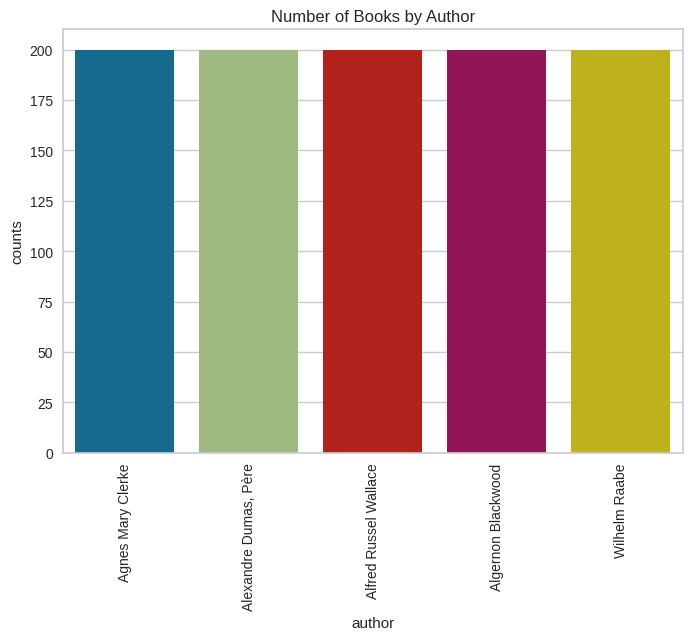

In [ ]:
# create a new DataFrame with the count of books by author
author_counts = df_books.groupby('author').size().reset_index(name='counts')

# plot the results using seaborn
ax = sns.barplot(x="author", y="counts", data=author_counts)

# rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# add title
plt.title('Number of Books by Author')

# show the plot
plt.show()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'count')

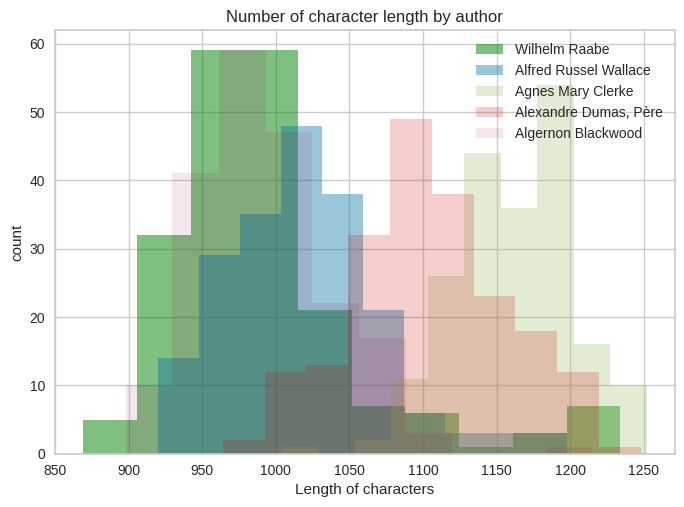

In [ ]:
df_books['char_length']=df_books['sentence'].apply(len)
df_books[df_books['label']==0]['char_length'].hist(label=df_books['label'],alpha=0.5,color=['green'] )
df_books[df_books['label']==1]['char_length'].hist(label=df_books['label'],alpha=0.4)
df_books[df_books['label']==2]['char_length'].hist(label=df_books['label'],alpha=0.3)
df_books[df_books['label']==3]['char_length'].hist(label=df_books['label'],alpha=0.2)
df_books[df_books['label']==4]['char_length'].hist(label=df_books['label'],alpha=0.1)
plt.legend([Author_dic.get(0),Author_dic.get(1),Author_dic.get(2),Author_dic.get(3),Author_dic.get(4)])
plt.title('Number of character length by author')
plt.xlabel('Length of characters')
plt.ylabel('count')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Name of Author  Wilhelm Raabe


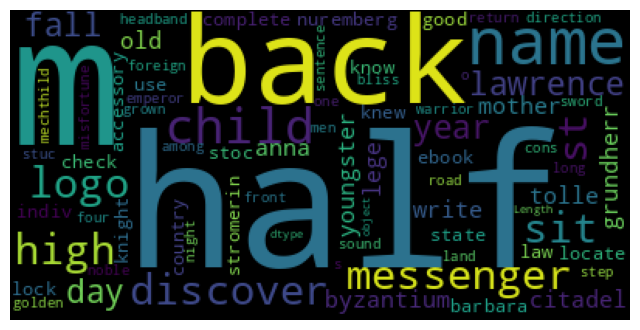

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Name of Author  Alfred Russel Wallace


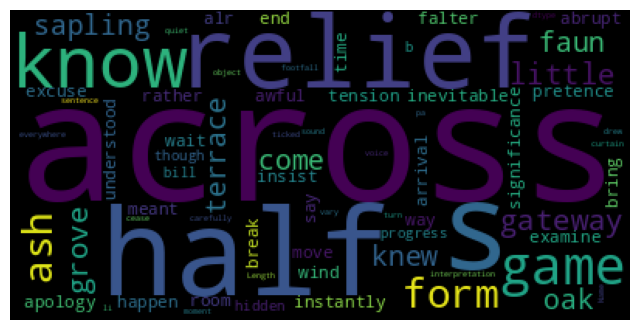

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Name of Author  Agnes Mary Clerke


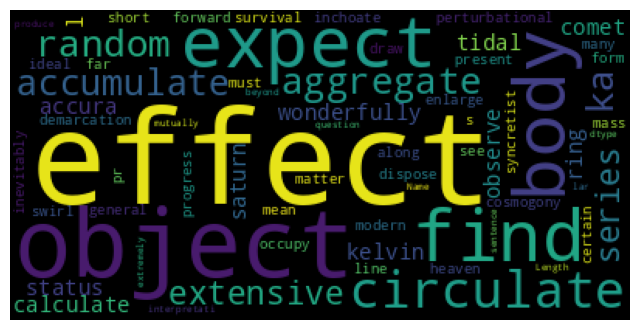

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Name of Author  Alexandre Dumas, Père


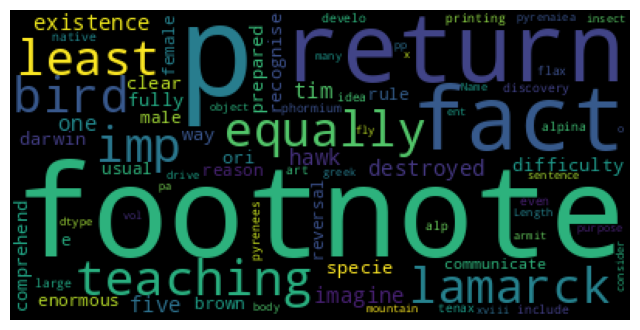

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Name of Author  Algernon Blackwood


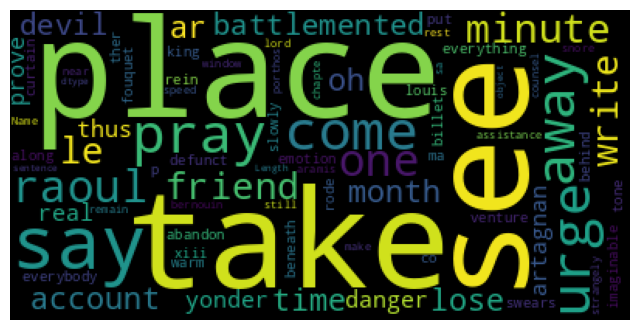

In [ ]:
for i in range (5):
 show_most_word_in_book(df_books,number_of_book=i,number_of_max_word=100)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


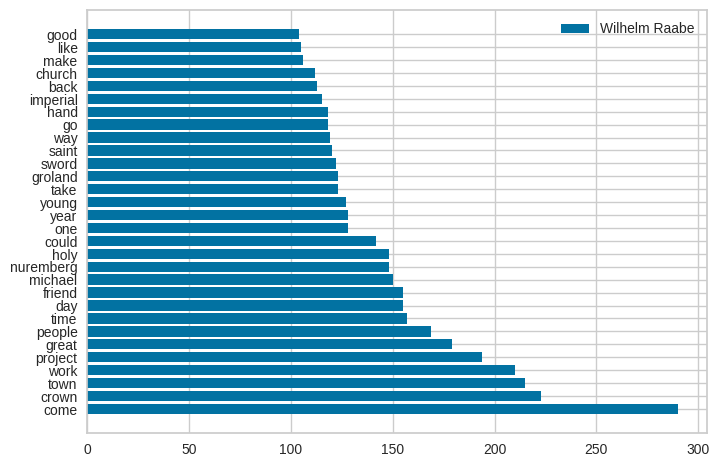

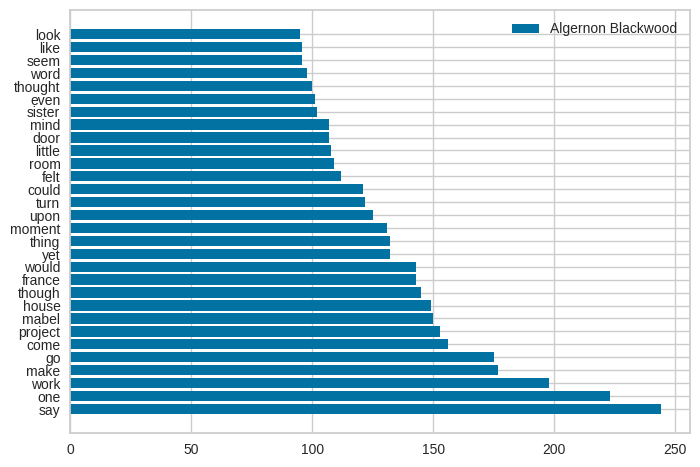

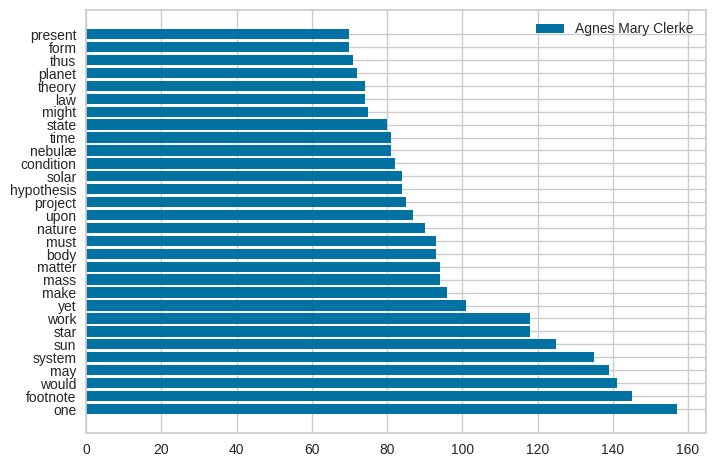

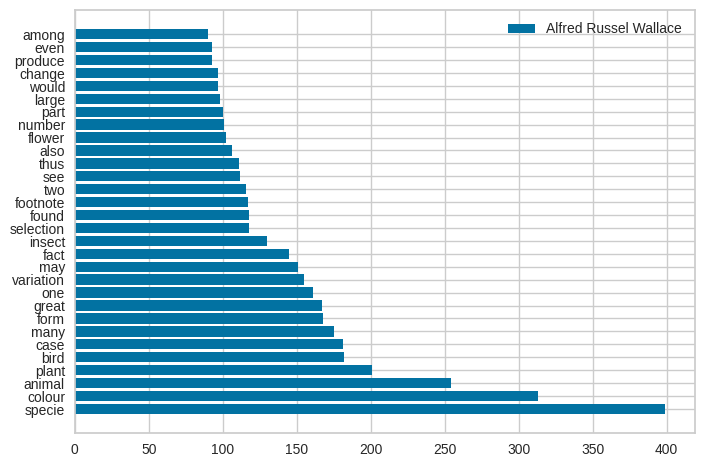

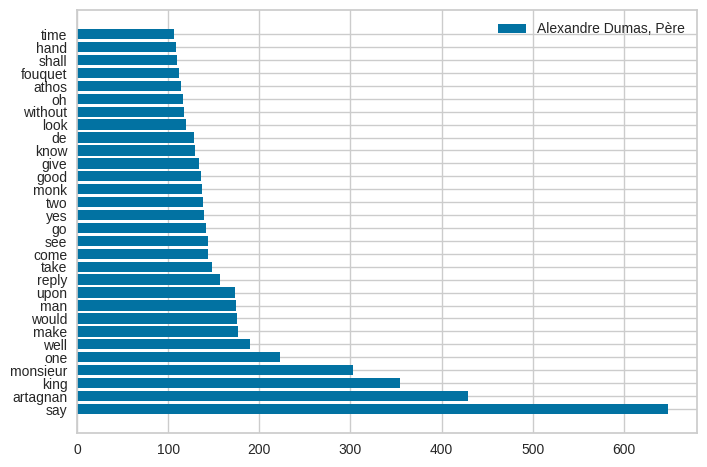

In [ ]:
# function to display top n words in each book
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]



for i in range(5):

    common_words = get_top_n_words(df_books[df_books['label']==i]['sentence'], 30)
    #for word, freq in common_words:
        #print(word, freq)

    df1 = pd.DataFrame(common_words, columns = ['word' , 'count'])
    #df1.groupby('word').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 30 words')
    #print(Author_dic.get(i))
    fig, ax = plt.subplots()
    ax.barh(df1['word'], df1['count'])
    ax.legend(df_books[df_books['label']==i]['author'])





In [ ]:
# split the data to intput  and Target
X = df_books['sentence']
Y = df_books['label']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## (4) Feature Engineering

### 4.1 Set of BOW

In [ ]:
# transform the data to a BOW

vect = CountVectorizer()
X_BOW = vect.fit_transform(X)
count_array = X_BOW.toarray()
df_books_BOW = pd.DataFrame(count_array,columns = vect.get_feature_names_out())
df_books_BOW

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


aachen  abandon  abash  abbe  abbey  abdon  abduction  abhor  abhors  \
0         0        0      0     0      0      0          0      0       0   
1         0        0      0     0      0      0          0      0       0   
2         0        0      0     0      0      0          0      0       0   
3         0        0      0     0      0      0          0      0       0   
4         0        0      0     0      0      0          0      0       0   
..      ...      ...    ...   ...    ...    ...        ...    ...     ...   
995       0        0      0     0      0      0          0      0       0   
996       0        0      0     0      0      0          0      0       0   
997       0        0      0     0      0      0          0      0       0   
998       0        0      0     0      0      0          0      0       0   
999       0        0      0     0      0      0          0      0       0   

     abide  ...  zool  zoological  zoologist  zoology  zoophyte  zöllner  \
0        0  ...     0           0          0        0         0        0   
1        0  ...     0           0          0        0         0        0   
2        0  ...     0           0          0        0         0        0   
3        0  ...     0           0          0        0         0        0   
4        0  ...     0           0          0        0         0        0   
..     ...  ...   ...         ...        ...      ...       ...      ...   
995      0  ...     0           0          0        0         0        0   
996      0  ...     0           0          0        0         0        0   
997      0  ...     0           0          0        0         0        0   
998      0  ...     0           0          0        0         0        0   
999      0  ...     0           0          0        0         0        0   

     æons  æsthetic  éclat  über  
0       0         0      0     0  
1       0         0      0     0  
2       0         0      0     0  
3       0         0      0     0  
4       0         0      0     0  
..    ...       ...    ...   ...  
995     0         0      0     0  
996     0         0      0     0  
997     0         0      0     0  
998     0         0      0     0  
999     0         0      0     0  

[1000 rows x 11086 columns]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


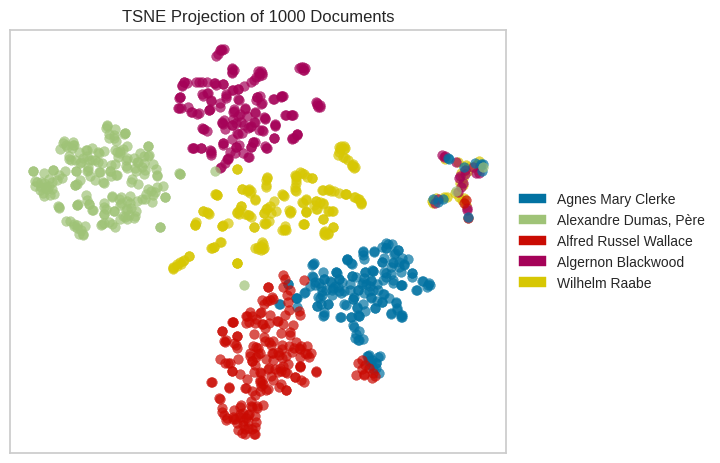

<Axes: title={'center': 'TSNE Projection of 1000 Documents'}>

In [ ]:
tsne = TSNEVisualizer()
tsne.fit(df_books_BOW,df_books['author'])
tsne.show()

### 4.2 set of TF IDF

In [ ]:
# transform the data to a tf-idf representation
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(df_books["sentence"])
#print(tfidf_vectorizer_vectors.toarray())
#print(tfidf_vectorizer.get_feature_names())
df_books_tf_idf = pd.DataFrame(tfidf_vectorizer_vectors.toarray(),columns=tfidf_vectorizer.get_feature_names_out())
df_books_tf_idf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


aachen  abandon  abash  abbe  abbey  abdon  abduction  abhor  abhors  \
0       0.0      0.0    0.0   0.0    0.0    0.0        0.0    0.0     0.0   
1       0.0      0.0    0.0   0.0    0.0    0.0        0.0    0.0     0.0   
2       0.0      0.0    0.0   0.0    0.0    0.0        0.0    0.0     0.0   
3       0.0      0.0    0.0   0.0    0.0    0.0        0.0    0.0     0.0   
4       0.0      0.0    0.0   0.0    0.0    0.0        0.0    0.0     0.0   
..      ...      ...    ...   ...    ...    ...        ...    ...     ...   
995     0.0      0.0    0.0   0.0    0.0    0.0        0.0    0.0     0.0   
996     0.0      0.0    0.0   0.0    0.0    0.0        0.0    0.0     0.0   
997     0.0      0.0    0.0   0.0    0.0    0.0        0.0    0.0     0.0   
998     0.0      0.0    0.0   0.0    0.0    0.0        0.0    0.0     0.0   
999     0.0      0.0    0.0   0.0    0.0    0.0        0.0    0.0     0.0   

     abide  ...  zool  zoological  zoologist  zoology  zoophyte  zöllner  \
0      0.0  ...   0.0         0.0        0.0      0.0       0.0      0.0   
1      0.0  ...   0.0         0.0        0.0      0.0       0.0      0.0   
2      0.0  ...   0.0         0.0        0.0      0.0       0.0      0.0   
3      0.0  ...   0.0         0.0        0.0      0.0       0.0      0.0   
4      0.0  ...   0.0         0.0        0.0      0.0       0.0      0.0   
..     ...  ...   ...         ...        ...      ...       ...      ...   
995    0.0  ...   0.0         0.0        0.0      0.0       0.0      0.0   
996    0.0  ...   0.0         0.0        0.0      0.0       0.0      0.0   
997    0.0  ...   0.0         0.0        0.0      0.0       0.0      0.0   
998    0.0  ...   0.0         0.0        0.0      0.0       0.0      0.0   
999    0.0  ...   0.0         0.0        0.0      0.0       0.0      0.0   

     æons  æsthetic  éclat  über  
0     0.0       0.0    0.0   0.0  
1     0.0       0.0    0.0   0.0  
2     0.0       0.0    0.0   0.0  
3     0.0       0.0    0.0   0.0  
4     0.0       0.0    0.0   0.0  
..    ...       ...    ...   ...  
995   0.0       0.0    0.0   0.0  
996   0.0       0.0    0.0   0.0  
997   0.0       0.0    0.0   0.0  
998   0.0       0.0    0.0   0.0  
999   0.0       0.0    0.0   0.0  

[1000 rows x 11086 columns]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


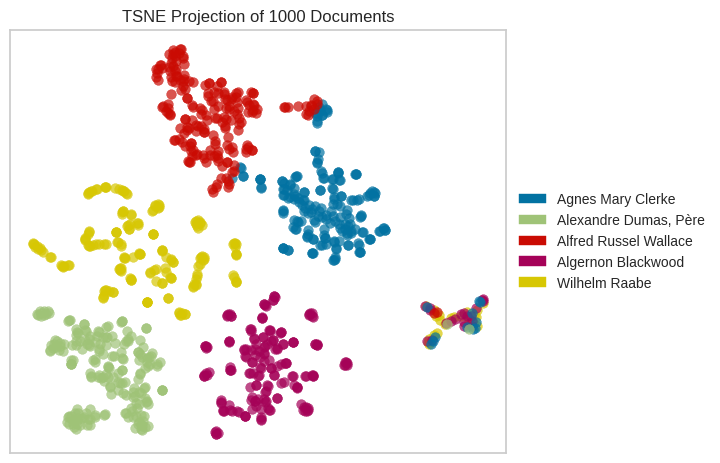

In [ ]:
tsne = TSNEVisualizer()
tsne.fit(df_books_tf_idf,df_books['author'])

tsne.show(legend=["Author 1","Author 2","Author 3","Author 4","Author 5"])
plt.show()

### 4.3 LDA

In [ ]:
# create a dictionary of the book words
wordsDictionary = corpora.Dictionary(df_books['sentence'].str.split())
corpus = [wordsDictionary.doc2bow(wordDic) for wordDic in df_books['sentence'].str.split()]


LDAModel = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = wordsDictionary,
                                           num_topics = 5,
                                           random_state = 42,
                                           update_every = 1,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',
                                           per_word_topics = True)
PredictedWords = LDAModel.inference(corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
PredictedWords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([[4.12147082e-02, 1.05984323e-01, 1.49932724e+02, 1.22015983e-01,
         1.43733740e-01],
        [4.12147082e-02, 1.05997294e-01, 8.40397644e+01, 2.25558186e+01,
         4.36208763e+01],
        [1.58595288e+00, 1.23554779e+02, 1.30533099e-01, 1.21955641e-01,
         2.49588318e+01],
        ...,
        [4.12147082e-02, 1.05994895e-01, 1.50051865e+02, 1.22088812e-01,
         1.43786773e-01],
        [4.12147082e-02, 1.05977759e-01, 1.50093414e+02, 1.21990114e-01,
         1.43661290e-01],
        [4.12147082e-02, 1.06001735e-01, 6.81011734e+01, 7.62571621e+00,
         7.45731583e+01]], dtype=float32),
 None)

In [ ]:
pyLDAvis.enable_notebook()
visualization = genisvis.prepare(LDAModel, corpus, wordsDictionary)
visualization

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.030649  0.140031       1        1  25.489346
2     -0.178961 -0.130050       2        1  25.142454
3     -0.129220 -0.076996       3        1  22.408232
1      0.046422  0.197274       4        1  20.937730
0      0.292409 -0.130260       5        1   6.022238, topic_info=          Term        Freq       Total Category  logprob  loglift
1008      work  512.000000  512.000000  Default  30.0000  30.0000
1456   project  402.000000  402.000000  Default  29.0000  29.0000
221        say  989.000000  989.000000  Default  28.0000  28.0000
1148  artagnan  396.000000  396.000000  Default  27.0000  27.0000
545     specie  398.000000  398.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
458        use   59.196387  150.694729   Topic5  -5.0278   1.8753
1437      full   54.022462  132.591926   Topic5  -5.1193   1.9118
423        may   57.158892  398.558592   Topic5  -5.0628   0.8677
301    include   41.780907  101.495901   Topic5  -5.3762   1.9221
557    without   45.592638  257.211974   Topic5  -5.2889   1.0796

[327 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1417      5  0.982734      access
1419      5  0.951839  additional
1764      3  0.138321       agree
1764      5  0.852979       agree
563       5  0.997338   agreement
...     ...       ...         ...
368       4  0.301726         yet
126       1  0.157107       young
126       2  0.572031       young
126       3  0.269902       young
3010      1  0.960982     zealand

[571 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

In [ ]:
LDA = pd.DataFrame(list(PredictedWords[0]), columns=['1', '2','3','4', '5'])
LDA['result'] = LDA.idxmax(axis = 1)
LDA.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1           2           3          4          5 result
0   0.041215    0.105984  149.932724   0.122016   0.143734      3
1   0.041215    0.105997   84.039764  22.555819  43.620876      3
2   1.585953  123.554779    0.130533   0.121956  24.958832      2
3   0.041215    0.106021   98.900063  21.763386  29.633888      3
4  28.740875   37.370216    0.130528   0.121967  83.293839      5

In [ ]:
PredictedWords

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([[4.12147082e-02, 1.05984323e-01, 1.49932724e+02, 1.22015983e-01,
         1.43733740e-01],
        [4.12147082e-02, 1.05997294e-01, 8.40397644e+01, 2.25558186e+01,
         4.36208763e+01],
        [1.58595288e+00, 1.23554779e+02, 1.30533099e-01, 1.21955641e-01,
         2.49588318e+01],
        ...,
        [4.12147082e-02, 1.05994895e-01, 1.50051865e+02, 1.22088812e-01,
         1.43786773e-01],
        [4.12147082e-02, 1.05977759e-01, 1.50093414e+02, 1.21990114e-01,
         1.43661290e-01],
        [4.12147082e-02, 1.06001735e-01, 6.81011734e+01, 7.62571621e+00,
         7.45731583e+01]], dtype=float32),
 None)

In [ ]:
LDA.sample(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1           2           3           4           5 result
32   0.041215    0.106005   67.821861    0.122088   82.298851      5
66   0.041215    0.105999   15.278025  125.815125    8.915962      4
34   0.041215    4.630587    2.586063    0.122056  142.174133      5
283  0.041215    0.105991   40.361607    0.122014  109.711823      5
698  4.315674  133.915665    0.130702    4.575485    7.398367      2
628  0.041215    0.105982  150.070175    0.121966    0.143647      3
436  0.041215    0.105990   19.331919  130.747589    0.143656      4
564  0.041215    0.105981  150.093094    0.121981    0.143724      3
706  0.041215    0.105996   16.513929  119.045555   14.653898      4
200  1.229845    0.105988  136.471649   12.511062    0.143779      3

### 4.4 Word Embedding (word2vec)

In [ ]:
# split our sentence to a list of words
SentencesToSplit = df_books['sentence'].tolist()
SplittedList = [x.split() for x in SentencesToSplit]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(len(SplittedList))
print(len(SplittedList[0]))

1000
150


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(SplittedList[0])

['half', 'child', 'half', 'messenger', 'high', 'discover', 'logo', 'make', 'sense', 'worldly', 'hubbub', 'give', 'peace', 'like', 'augustine', 'longer', 'breathe', 'air', 'bread', 'circus', 'military', 'might', 'emperor', 'erstwhile', 'glory', 'indeed', 'splendour', 'rome', 'heard', 'saw', 'thing', 'wonderful', 'tell', 'describe', 'still', 'young', 'saw', 'bright', 'light', 'gloom', 'still', 'young', 'life', 'also', 'underwent', 'change', 'great', 'bell', 'benedicta', 'church', 'saint', 'sebaldus', 'want', 'solemn', 'toll', 'bell', 'belltowers', 'home', 'town', 'want', 'ring', 'hear', 'tone', 'near', 'far', 'intermingle', 'hear', 'brother', 'sister', 'make', 'way', 'street', 'marketplace', 'sing', 'psalm', 'plaintive', 'hymn', 'hear', 'people', 'tramp', 'like', 'roar', 'faraway', 'river', 'break', 'bank', 'churchyard', 'saint', 'sebaldus', 'sound', 'iron', 'clapper', 'voice', 'stream', 'one', 'vox', 'ego', 'sum', 'vitae', 'voco', 'vos', 'orate', 'venite', 'voice', 'life', 'call', 'pray

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# build word_embeddings model
word_embeddings_model = Word2Vec(SplittedList,
                            vector_size = len(SplittedList[0]),
                            min_count= 1,
                            workers=6,
                            window= 3,
                            sg= 1)
# save trained model
word_embeddings_model.save("word_embeddings_model.model")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def vectorize_docs(documents, word_embeddings_model):
    document_embeddings = []

    for doc_tokens in documents:
        zero_vector = np.zeros(word_embeddings_model.vector_size)
        token_embeddings = []
        for token in doc_tokens:
            if token in word_embeddings_model.wv:
                try:
                    token_embeddings.append(word_embeddings_model.wv[token])
                except KeyError:
                    continue
        if token_embeddings:
            token_embeddings = np.asarray(token_embeddings)
            avg_doc_embedding = token_embeddings.mean(axis=0)
            document_embeddings.append(avg_doc_embedding)
        else:
            document_embeddings.append(zero_vector)
    return document_embeddings

vectorized_docs = vectorize_docs(SplittedList, word_embeddings_model=word_embeddings_model)
document_embeddings = np.array(vectorized_docs)
len(vectorized_docs), len(vectorized_docs[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1000, 150)

In [ ]:
print(vectorized_docs[0])

[ 0.01037092 -0.01678682 -0.07521727  0.00458486  0.2223188   0.00154048
 -0.12182119  0.32594147  0.07134296  0.09678854  0.10755903 -0.05733206
 -0.0668935   0.11390691 -0.23886973 -0.00097043  0.03980597 -0.15627016
 -0.01209488  0.30480072 -0.12780377 -0.04022014  0.11936542  0.07076063
  0.14959271  0.07513668 -0.12631875 -0.07085946 -0.07682614 -0.15998057
 -0.04901443  0.11070156 -0.0194509  -0.11388925 -0.05088202 -0.02877268
  0.2480938   0.10742459  0.22948514 -0.1826965  -0.04307009  0.02303656
 -0.14436541 -0.06625766  0.08619523  0.00740569  0.04585157  0.11219039
 -0.11459982  0.19330774 -0.09414732  0.04999454 -0.19432081 -0.05752908
 -0.06612711  0.1930504  -0.04758674  0.08155711 -0.02832458  0.00769949
 -0.10601158 -0.17930183 -0.19340406  0.05089835  0.13882987 -0.0852828
 -0.08320747 -0.23168932 -0.27455682 -0.13165131  0.15984206  0.13540949
  0.05261063 -0.36392695 -0.14242136 -0.0524765  -0.0579896   0.05002953
 -0.15611424  0.15988608  0.05474166 -0.25364986 -0.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Necessary Functions for visualization

In [ ]:
# perform dimensionality reduction for each text transformation result using tSNE
def TSNEData(data):
  Tsna = TSNE(n_components= 2, random_state= 42)
  DataOfTSNE = Tsna.fit_transform(data)
  return DataOfTSNE

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
DataOfBOW = TSNEData(df_books_BOW)
DataOfTFIDF = TSNEData(df_books_tf_idf)
DataOfLDA = TSNEData(PredictedWords[0])
W2VData = TSNEData(document_embeddings)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(DataOfBOW)
print(DataOfTFIDF)
print(DataOfLDA)
print(W2VData)

[[-50.299442   20.888502 ]
 [-13.372699    5.8894377]
 [ 31.842842   13.592379 ]
 ...
 [-51.347485   16.027657 ]
 [-52.78285    -3.3306963]
 [-19.868279   13.791053 ]]
[[ 15.849869   -46.281414  ]
 [  6.2395215  -20.661861  ]
 [ 26.315819    34.441006  ]
 ...
 [ 11.374891   -53.771957  ]
 [  0.90012926 -46.28282   ]
 [ -3.4856155  -19.958221  ]]
[[ 43.037743   -2.4897203]
 [ 17.028852   -2.339133 ]
 [-29.062315   -7.176766 ]
 ...
 [ 45.429684   -3.617027 ]
 [ 44.344566  -15.926449 ]
 [ 13.5194235  -8.101555 ]]
[[-33.014915  -9.501364]
 [-19.807713  12.227382]
 [ 22.672379 -13.624769]
 ...
 [-34.78134   -8.844266]
 [-46.279697  -9.52579 ]
 [-17.206087   7.147562]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# function to visualize the five clusters
def Visualize_Clusters(ClusteringModel, result, Y_Prediction, em=True,title=''):
    # get centroids of kmeans cluster
    if em:
        centroids = np.empty(shape=(ClusteringModel.n_components, result.shape[1]))
    else:
        centroids = ClusteringModel.cluster_centers_

  # we want to transform the rows and the centroids
  # todense return matrix
    matrix_data = csr_matrix(result)
    all_Data = concatenate((matrix_data.todense(), centroids))

    n_clusters = 5

    plt.scatter([all_Data[:-n_clusters, 0]], [all_Data[:-n_clusters, 1]], c=Y_Prediction, cmap=plt.cm.Paired, marker= 'x')
    plt.scatter([all_Data[-n_clusters:, 0]], [all_Data[-n_clusters:, 1]], marker= 'o')
    # Set the x-axis label
    plt.xlabel('X-Label')
    # Set the y-axis label
    plt.ylabel('Y-Label')
    # Set the title
    plt.title(title)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# function to display histogram of each cluster
def Clusters_Count(predictedClusters,title=''):
    clustersNumber = Counter(predictedClusters)
    plt.bar(clustersNumber.keys(), clustersNumber.values())
    plt.xlabel('Cluster Number')
    plt.ylabel('Count')
    # Set the title
    plt.title(title)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## (5) Applying Clustering Algorithms

### 5.1 K-Means algorithm

In [ ]:
# function to apply kmeans algorithm
def KMeansAlgorithm(clusters, X_data):
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    Y_Prediction = kmeans.fit_predict(X_data)
    return kmeans, Y_Prediction

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### BOW with Kmeans

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


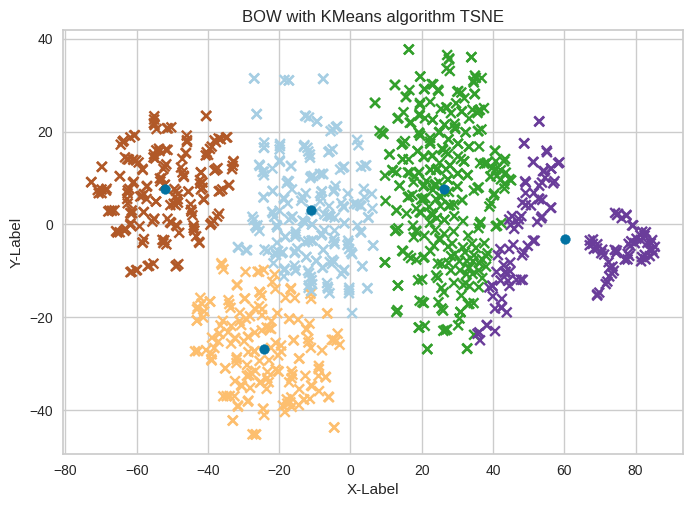

In [ ]:
# Bow with KMeans algorithm
KMeansWithBOW, KMeansWithBOWPrediction = KMeansAlgorithm(5,DataOfBOW)
# visualize clusters
Visualize_Clusters(KMeansWithBOW, DataOfBOW, KMeansWithBOWPrediction,False,title='BOW with KMeans algorithm TSNE')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


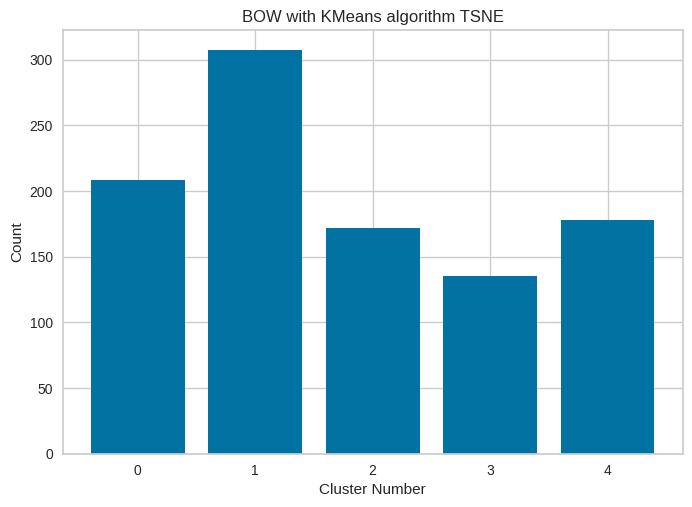

In [ ]:
Clusters_Count(KMeansWithBOWPrediction,title='BOW with KMeans algorithm TSNE')

#### TF-IDF with KMeans algorithm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


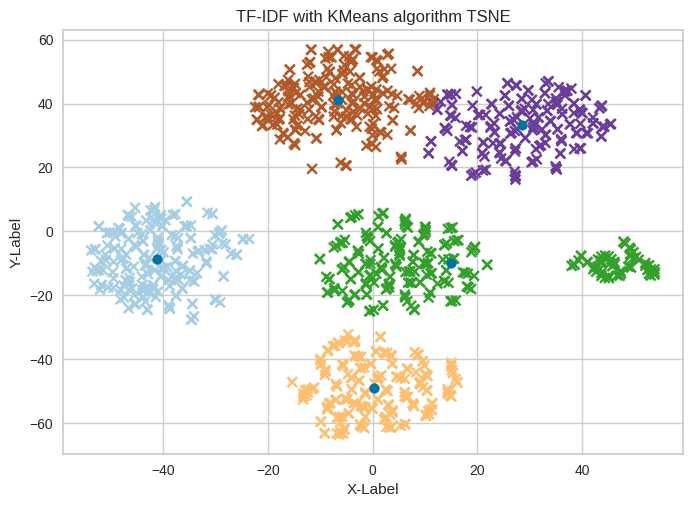

In [ ]:
# tf-idf with KMeans algorithm
KMeansWithTFIDF, KMeansWithTFIDFPrediction = KMeansAlgorithm(5,DataOfTFIDF)
# visualize clusters
Visualize_Clusters(KMeansWithTFIDF, DataOfTFIDF, KMeansWithTFIDFPrediction,False,title='TF-IDF with KMeans algorithm TSNE')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


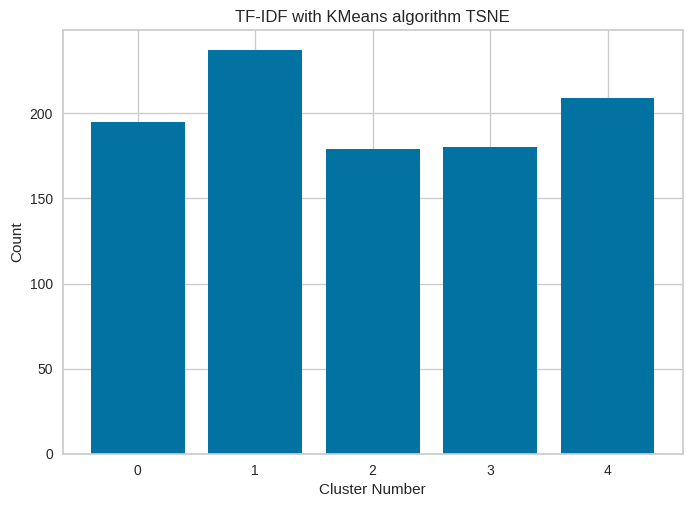

In [ ]:
# visualize cluster number
Clusters_Count(KMeansWithTFIDFPrediction,title='TF-IDF with KMeans algorithm TSNE')

#### LDA with Kmeans

In [ ]:
# LDA with KMeans algorithm
KMeansWithLDA, KMeansWithLDAPrediction = KMeansAlgorithm(5,DataOfLDA)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


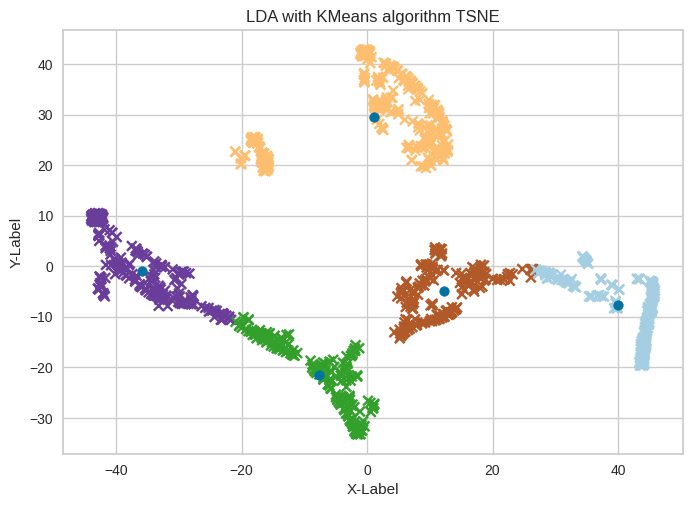

In [ ]:
# visualize clusters
Visualize_Clusters(KMeansWithLDA, DataOfLDA, KMeansWithLDAPrediction,False,title='LDA with KMeans algorithm TSNE')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


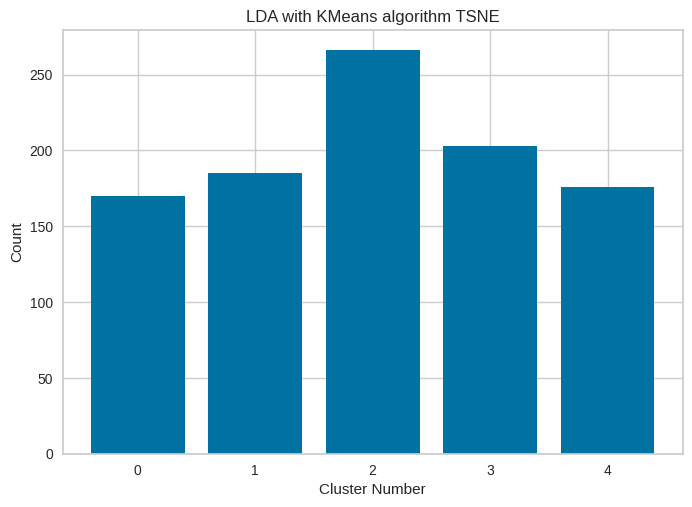

In [ ]:
# visualize cluster number
Clusters_Count(KMeansWithLDAPrediction,title='LDA with KMeans algorithm TSNE')

#### word2vec with Kmeans

In [ ]:
# word2vec with Kmeans
W2VWithKMeans, W2VWithKMeansPrediction = KMeansAlgorithm(5,W2VData)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


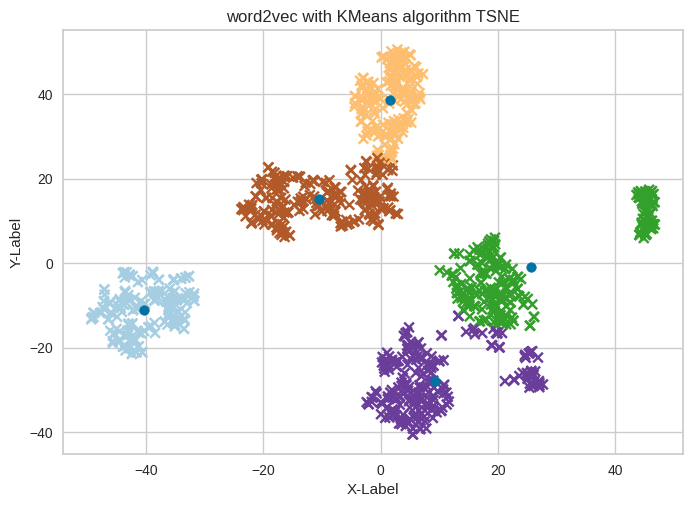

In [ ]:
Visualize_Clusters(W2VWithKMeans, W2VData, W2VWithKMeansPrediction,False,title='word2vec with KMeans algorithm TSNE')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


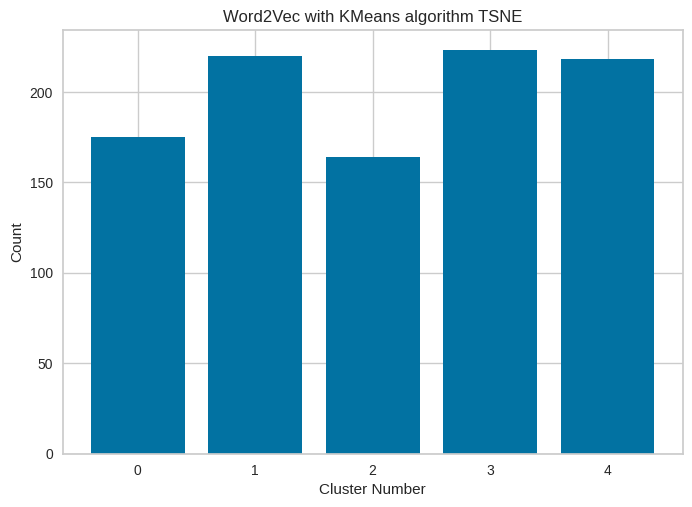

In [ ]:
Clusters_Count(W2VWithKMeansPrediction,title='Word2Vec with KMeans algorithm TSNE')

### 5.2 Expectation Maximization(EM) algorithm

In [ ]:
# function to apply EM algorithm
def ExpectationMaximization(clusters, X_data):
    gm= GaussianMixture(n_components=clusters ,covariance_type= "spherical" ,n_init= 10 )
    Y_Prediction= gm.fit_predict(X_data)
    ProbabilityOfGM = gm.predict_proba(X_data)
    return gm, Y_Prediction, ProbabilityOfGM

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### BOW with Expectation Maximization(EM) algorithm

In [ ]:
#BOW with EM
EMWithBOW, EMWithBOWPrediction, EMWithBOWProbability = ExpectationMaximization(5,DataOfBOW)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


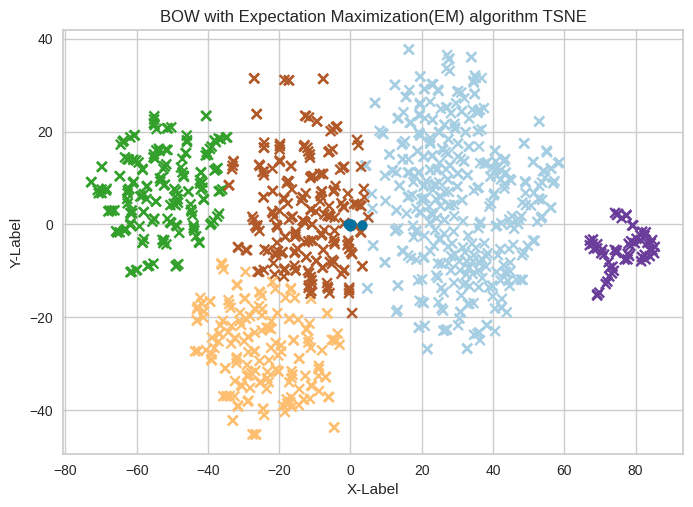

In [ ]:
#BOW with Expectation Maximization(EM) algorithm
Visualize_Clusters(EMWithBOW, DataOfBOW, EMWithBOWPrediction,True,title='BOW with Expectation Maximization(EM) algorithm TSNE')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


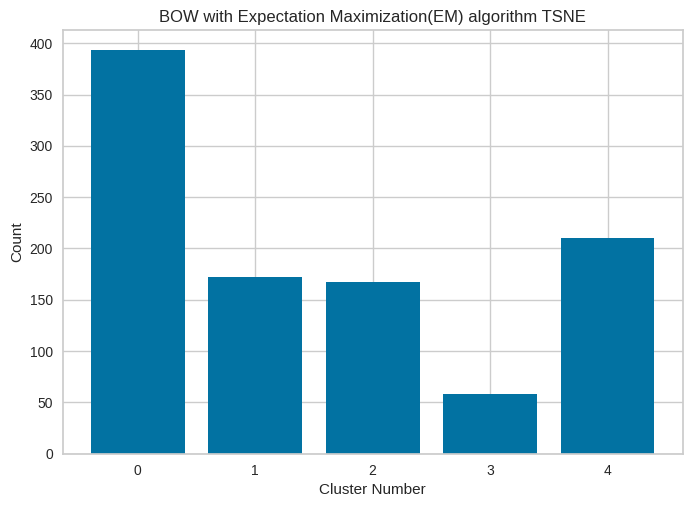

In [ ]:
Clusters_Count(EMWithBOWPrediction,title='BOW with Expectation Maximization(EM) algorithm TSNE')

#### TF-IDF with Expectation Maximization(EM) algorithm

In [ ]:
# TF-IDF with Expectation Maximization(EM) algorithm
EMWithTFIDF, EMWithTFIDFPrediction, EMWithTFIDFProbability = ExpectationMaximization(5,DataOfTFIDF)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


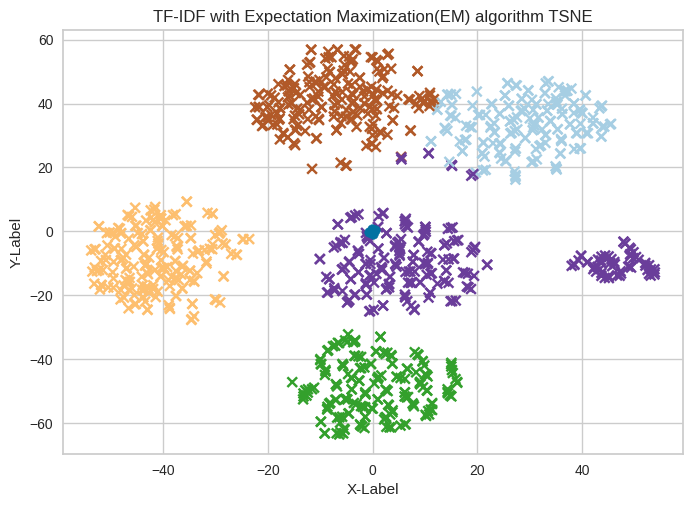

In [ ]:
Visualize_Clusters(EMWithTFIDF, DataOfTFIDF, EMWithTFIDFPrediction,True,title='TF-IDF with Expectation Maximization(EM) algorithm TSNE')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


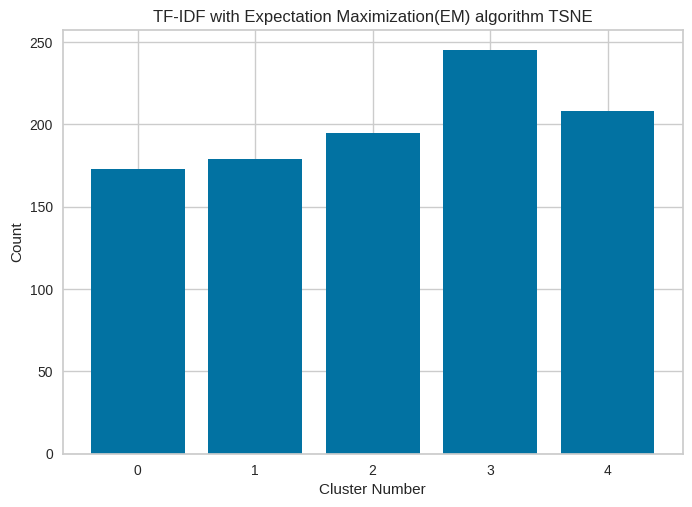

In [ ]:
Clusters_Count(EMWithTFIDFPrediction,title='TF-IDF with Expectation Maximization(EM) algorithm TSNE')

#### LDA with Expectation Maximization(EM) algorithm

In [ ]:
# LDA with Expectation Maximization(EM) algorithm
EMWithLDA, EMWithLDAPrediction, EMWithLDAProbability = ExpectationMaximization(5, DataOfLDA)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


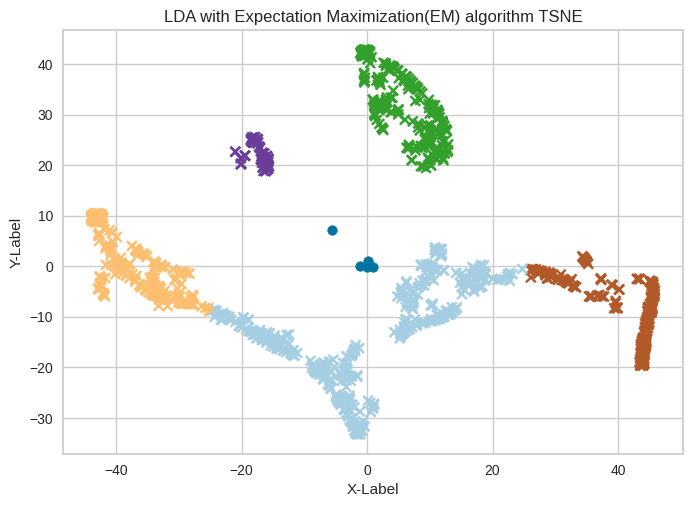

In [ ]:
Visualize_Clusters(EMWithLDA, DataOfLDA, EMWithLDAPrediction,True,title='LDA with Expectation Maximization(EM) algorithm TSNE')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


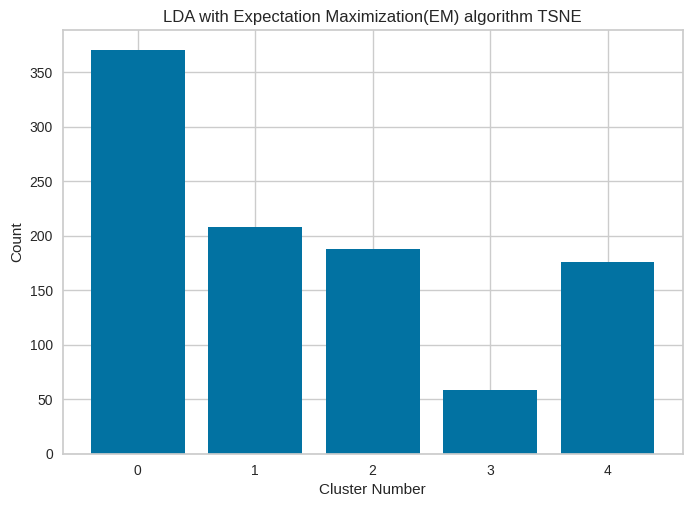

In [ ]:
Clusters_Count(EMWithLDAPrediction,title='LDA with Expectation Maximization(EM) algorithm TSNE')

#### Word2Vec with Expectation Maximization(EM) algorithm

In [ ]:
W2VWithEM, W2VWithEMPrediction, W2VWithEMProbability = ExpectationMaximization(5,W2VData)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


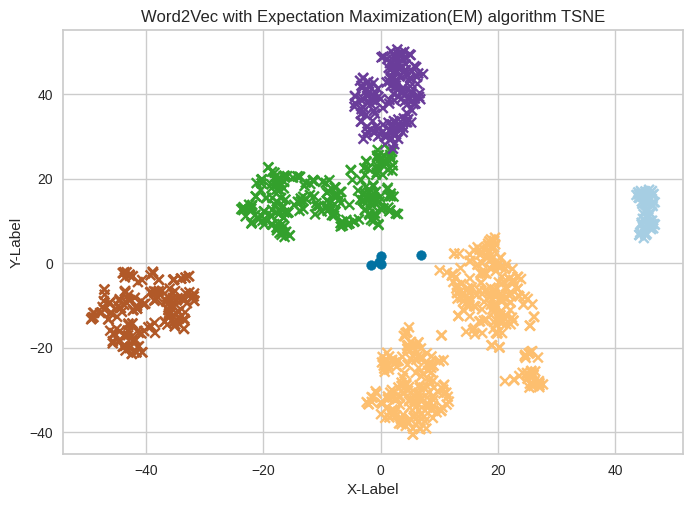

In [ ]:
Visualize_Clusters(W2VWithEM, W2VData, W2VWithEMPrediction,True,title='Word2Vec with Expectation Maximization(EM) algorithm TSNE')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


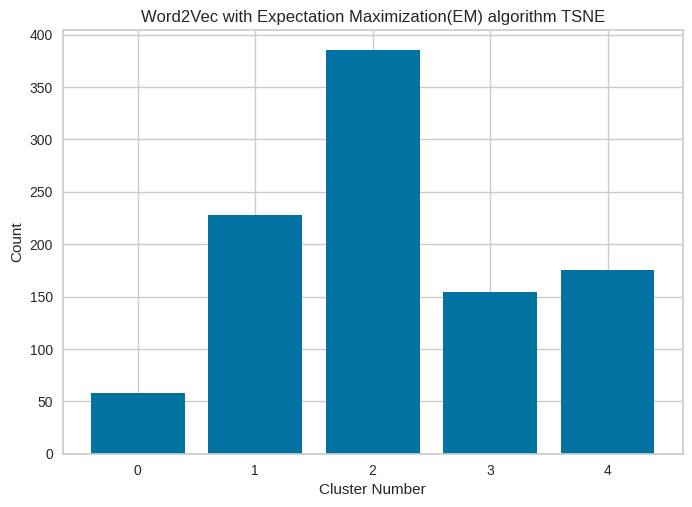

In [ ]:
Clusters_Count(W2VWithEMPrediction,title='Word2Vec with Expectation Maximization(EM) algorithm TSNE')

### 5.3 Hierarchical clustering algorithm

In [ ]:
# function to apply EM algorithm
def HierarchicalClustering(clusters, X_data, title):
    plt.figure(figsize=(10, 7))
    plt.title(title)
    dendro = shc.dendrogram(shc.linkage(X_data, method='ward'))
    agg = AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='ward')
    Y_Prediction= agg.fit_predict(X_data)
    return agg, Y_Prediction

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### BOW with Hierarchical algorithm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


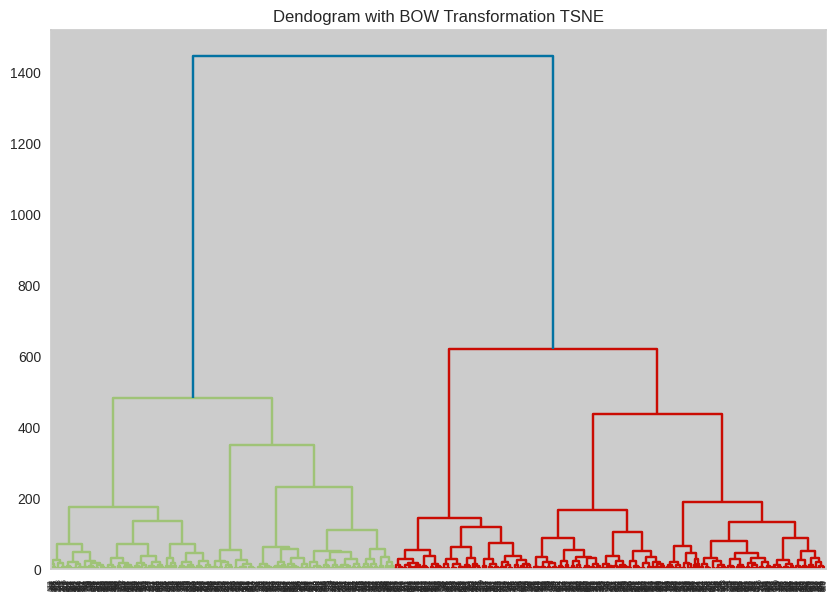

In [ ]:
# BOW with Hierarchical algorithm
AggClusteringWithBOW, AggClusteringWithBOWPrediction= HierarchicalClustering(5, DataOfBOW,"Dendogram with BOW Transformation TSNE")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


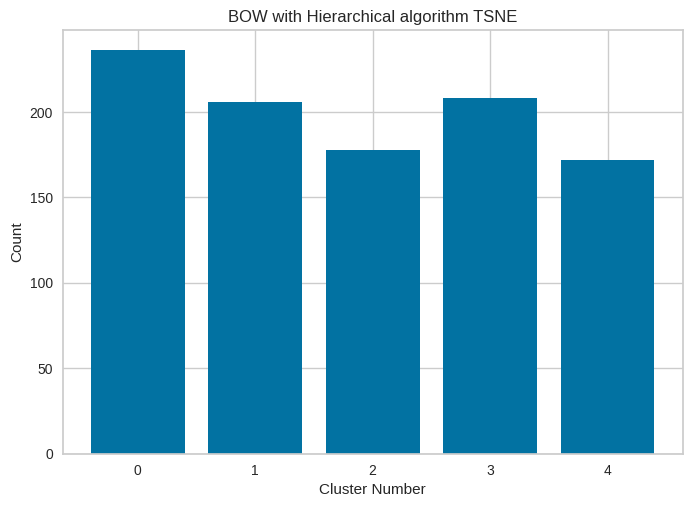

In [ ]:
Clusters_Count(AggClusteringWithBOWPrediction,title='BOW with Hierarchical algorithm TSNE')

#### TF-IDF with Hierarchical algorithm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


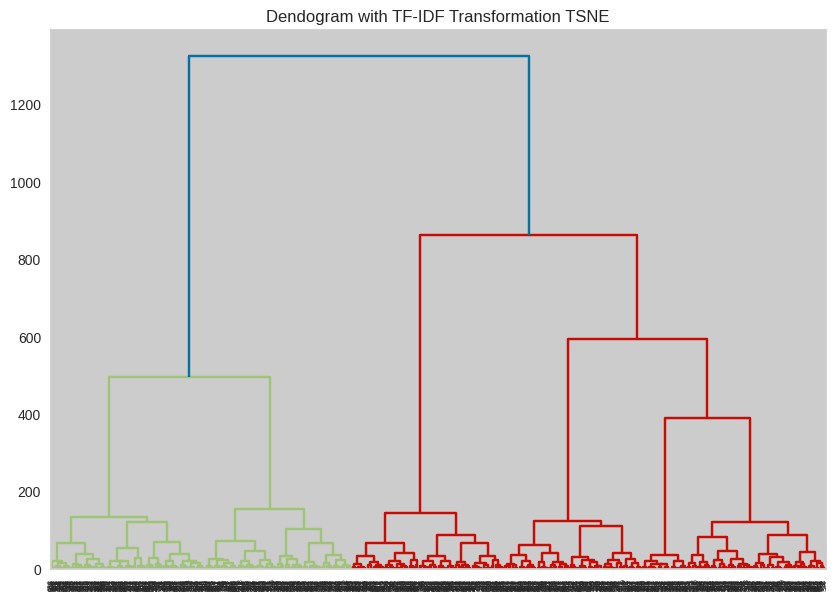

In [ ]:
# TF-IDF with Hierarchical algorithm
HCWithTFIDF, HCWithTFIDFPrediction= HierarchicalClustering(5, DataOfTFIDF,"Dendogram with TF-IDF Transformation TSNE")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


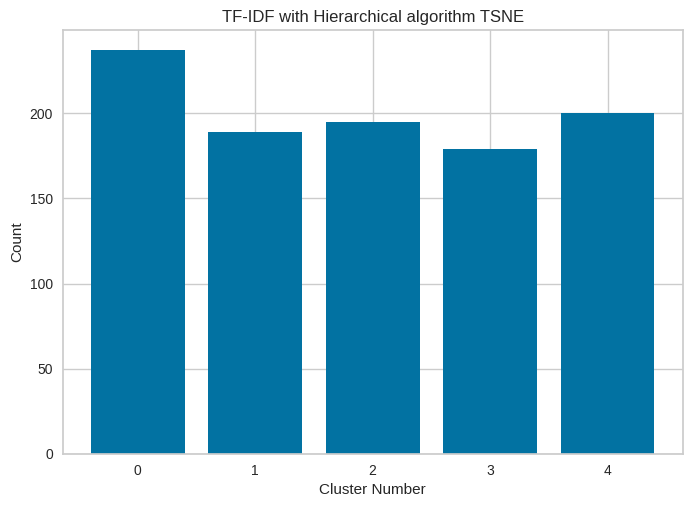

In [ ]:
Clusters_Count(HCWithTFIDFPrediction,title='TF-IDF with Hierarchical algorithm TSNE')

#### LDA with Hierarchical algorithm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


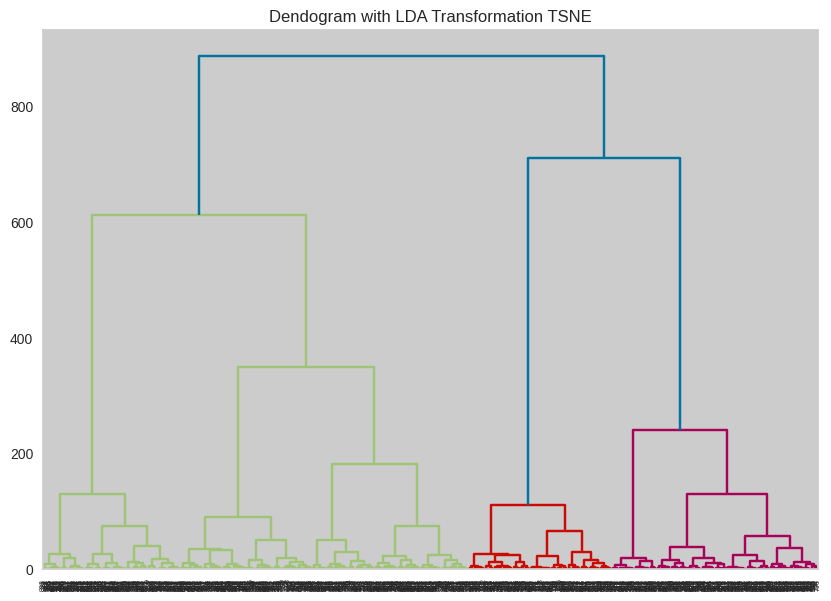

In [ ]:
# LDA with Hierarchical algorithm
HCWithLDA, HCWithLDAPrediction= HierarchicalClustering(5, DataOfLDA, "Dendogram with LDA Transformation TSNE")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


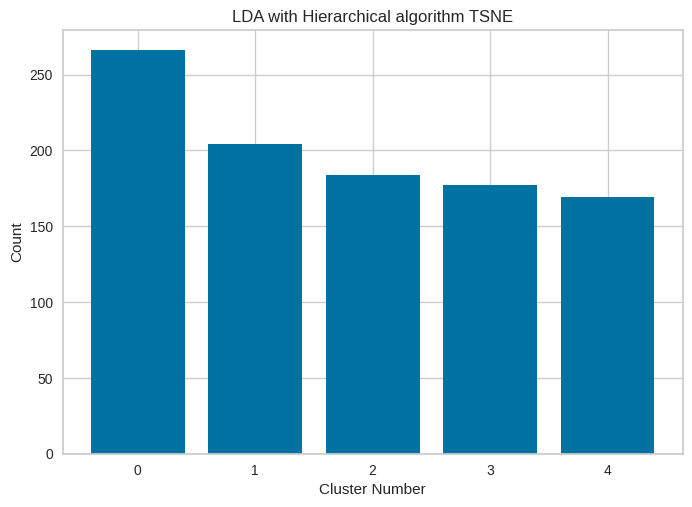

In [ ]:
Clusters_Count(HCWithLDAPrediction,title='LDA with Hierarchical algorithm TSNE')

#### word2vec with  Hierarchical algorithm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


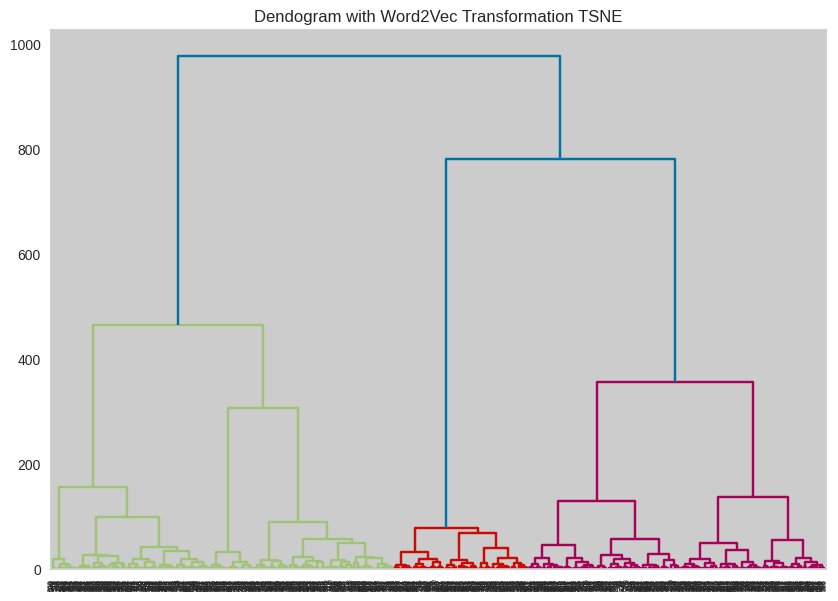

In [ ]:
# word2vec with  Hierarchical algorithm
W2VWithHC, W2VWithHCPrediction= HierarchicalClustering(5, W2VData,"Dendogram with Word2Vec Transformation TSNE")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


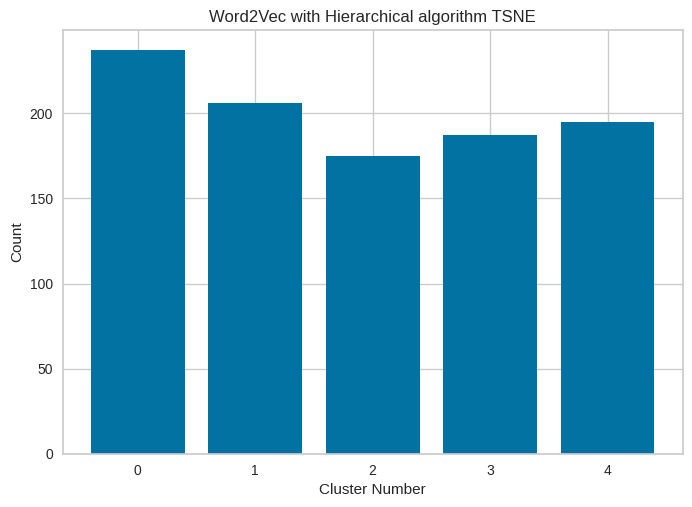

In [ ]:
Clusters_Count(W2VWithHCPrediction,title='Word2Vec with Hierarchical algorithm TSNE')

### (6) Evaluation

#### 6.1 Kappa against true authors

In [ ]:
# function for making evaluation
def majority_class(rater1_labels, rater2_labels, num_labels):
    # Initialize an empty list to hold the majority label for each cluster
    max_labels = []

    # Loop through each label cluster
    for cluster_label in range(num_labels):
        # Initialize a list to hold the counts of each possible label value for rater2's labels within this cluster
        label_counts = [0] * num_labels

        # Loop through each possible label value for rater2's labels
        for rater2_label in range(num_labels):
            # Count the number of instances where rater1 has the current cluster label and rater2 has the current label value
            count = 0
            for index in range(len(rater2_labels)):
                if rater1_labels[index] == cluster_label and rater2_labels[index] == rater2_label:
                    count += 1

            # Record the count for this label value
            label_counts[rater2_label] = count

        # Print the label counts for debugging purposes
        print("Label counts for cluster " + str(cluster_label) + ": " + str(label_counts))

        # Find the index of the label value with the highest count
        max_label_index = np.argmax(label_counts)

        # Record the corresponding label value as the majority for this cluster
        max_labels.append(max_label_index)

        # Move on to the next cluster label
        cluster_label += 1

    # Return the list of majority labels for each cluster
    return max_labels

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# function for mapping
def mapping_labels(rater_labels, max_labels, num_labels):
    # Initialize a list of booleans indicating which indices of rater_labels have not been mapped yet
    unmapped_indices = [True] * len(rater_labels)

    # Loop through each possible label value
    for label_value in range(num_labels):
        # Loop through each index of rater_labels
        for index in range(len(rater_labels)):
            # If this index hasn't been mapped yet and has the current label value
            if unmapped_indices[index] and rater_labels[index] == label_value:
                # Map the rater label to the corresponding max label value
                rater_labels[index] = max_labels[label_value]
                # Mark this index as mapped
                unmapped_indices[index] = False

    # Return the list of mapped rater labels
    return rater_labels

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def kappa_implement(data, title=''):
    print(title)
    Max = majority_class(list(data), list(df_books['label']), 5)
    data = mapping_labels(list(data), Max, 5)
    score=cohen_kappa_score(df_books['label'],data)
    print("Kappa Score:  {:.5f}".format(cohen_kappa_score(df_books['label'],data)))
    return score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Kappa with K-means

In [ ]:
x=kappa_implement(KMeansWithBOWPrediction,'Kappa with K-means for BOW')
print(x)

Kappa with K-means for BOW
Label counts for cluster 0: [0, 176, 0, 4, 28]
Label counts for cluster 1: [0, 0, 189, 117, 1]
Label counts for cluster 2: [0, 4, 0, 0, 168]
Label counts for cluster 3: [23, 20, 11, 79, 2]
Label counts for cluster 4: [177, 0, 0, 0, 1]
Kappa Score:  0.73625
0.7362500000000001


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Kmeans_Kappa_score =[]
Kmeans_Kappa_score.append(kappa_implement(KMeansWithBOWPrediction,'Kappa with K-means for BOW'))
Kmeans_Kappa_score.append(kappa_implement(KMeansWithTFIDFPrediction,'Kappa with K-means for TF-IDF'))
Kmeans_Kappa_score.append(kappa_implement(KMeansWithLDAPrediction,'Kappa with K-means for LDA'))
Kmeans_Kappa_score.append(kappa_implement(W2VWithKMeansPrediction,'Kappa with K-means for Word2Vec'))
print("Kappa Scores with Kmeans",Kmeans_Kappa_score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Kappa with K-means for BOW
Label counts for cluster 0: [0, 176, 0, 4, 28]
Label counts for cluster 1: [0, 0, 189, 117, 1]
Label counts for cluster 2: [0, 4, 0, 0, 168]
Label counts for cluster 3: [23, 20, 11, 79, 2]
Label counts for cluster 4: [177, 0, 0, 0, 1]
Kappa Score:  0.73625
Kappa with K-means for TF-IDF
Label counts for cluster 0: [0, 0, 0, 0, 195]
Label counts for cluster 1: [23, 199, 11, 2, 2]
Label counts for cluster 2: [177, 0, 0, 0, 2]
Label counts for cluster 3: [0, 0, 180, 0, 0]
Label counts for cluster 4: [0, 1, 9, 198, 1]
Kappa Score:  0.93625
Kappa with K-means for LDA
Label counts for cluster 0: [170, 0, 0, 0, 0]
Label counts for cluster 1: [0, 7, 0, 178, 0]
Label counts for cluster 2: [23, 32, 11, 2, 198]
Label counts for cluster 3: [0, 0, 189, 14, 0]
Label counts for cluster 4: [7, 161, 0, 6, 2]
Kappa Score:  0.87000
Kappa with K-means for Word2Vec
Label counts for cluster 0: [175, 0, 0, 0, 0]
Label counts for cluster 1: [23, 20, 167, 8, 2]
Label counts for cluste

#### Kappa with Hierarchical Algorithm

In [ ]:
Hierarchical_Kappa_score=[]
Hierarchical_Kappa_score.append(kappa_implement(AggClusteringWithBOWPrediction,'Kappa with Hierarchical for BOW'))
Hierarchical_Kappa_score.append(kappa_implement(HCWithTFIDFPrediction,'Kappa with Hierarchical for TF-IDF'))
Hierarchical_Kappa_score.append(kappa_implement(HCWithLDAPrediction,'Kappa with Hierarchical for LDA'))
Hierarchical_Kappa_score.append(kappa_implement(W2VWithHCPrediction,'Kappa with Hierarchical for Word2Vec'))
print("Kappa scores with Hierarchical",Hierarchical_Kappa_score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Kappa with Hierarchical for BOW
Label counts for cluster 0: [23, 20, 24, 166, 3]
Label counts for cluster 1: [0, 172, 3, 8, 23]
Label counts for cluster 2: [177, 0, 0, 0, 1]
Label counts for cluster 3: [0, 6, 173, 26, 3]
Label counts for cluster 4: [0, 2, 0, 0, 170]
Kappa Score:  0.82250
Kappa with Hierarchical for TF-IDF
Label counts for cluster 0: [23, 199, 11, 2, 2]
Label counts for cluster 1: [0, 0, 179, 10, 0]
Label counts for cluster 2: [0, 0, 0, 0, 195]
Label counts for cluster 3: [177, 0, 0, 0, 2]
Label counts for cluster 4: [0, 1, 10, 188, 1]
Kappa Score:  0.92250
Kappa with Hierarchical for LDA
Label counts for cluster 0: [23, 32, 11, 2, 198]
Label counts for cluster 1: [0, 7, 5, 192, 0]
Label counts for cluster 2: [0, 0, 184, 0, 0]
Label counts for cluster 3: [177, 0, 0, 0, 0]
Label counts for cluster 4: [0, 161, 0, 6, 2]
Kappa Score:  0.89000
Kappa with Hierarchical for Word2Vec
Label counts for cluster 0: [23, 20, 180, 12, 2]
Label counts for cluster 1: [0, 0, 20, 185, 1]


#### Kappa with Expectation Maximization (EM) Algorithm

In [ ]:
EM_Kappa_score = []
EM_Kappa_score.append(kappa_implement(EMWithBOWPrediction,'Kappa with Expectation Maximization for BOW'))
EM_Kappa_score.append(kappa_implement(EMWithTFIDFPrediction,'Kappa with Expectation Maximization for TF-IDF'))
EM_Kappa_score.append(kappa_implement(EMWithLDAPrediction,'Kappa with Expectation Maximization for LDA'))
EM_Kappa_score.append(kappa_implement(W2VWithEMPrediction,'Kappa with Expectation Maximization for Word2Vec'))
print("Kappa Scores with EM",EM_Kappa_score)

Kappa with Expectation Maximization for BOW
Label counts for cluster 0: [0, 3, 189, 195, 6]
Label counts for cluster 1: [171, 0, 0, 0, 1]
Label counts for cluster 2: [0, 3, 0, 0, 164]
Label counts for cluster 3: [23, 20, 11, 2, 2]
Label counts for cluster 4: [6, 174, 0, 3, 27]
Kappa Score:  0.65875
Kappa with Expectation Maximization for TF-IDF
Label counts for cluster 0: [0, 0, 173, 0, 0]
Label counts for cluster 1: [177, 0, 0, 0, 2]
Label counts for cluster 2: [0, 0, 0, 0, 195]
Label counts for cluster 3: [23, 199, 19, 2, 2]
Label counts for cluster 4: [0, 1, 8, 198, 1]
Kappa Score:  0.92750
Kappa with Expectation Maximization for LDA
Label counts for cluster 0: [1, 168, 1, 198, 2]
Label counts for cluster 1: [0, 12, 0, 0, 196]
Label counts for cluster 2: [0, 0, 188, 0, 0]
Label counts for cluster 3: [23, 20, 11, 2, 2]
Label counts for cluster 4: [176, 0, 0, 0, 0]
Kappa Score:  0.72625
Kappa with Expectation Maximization for Word2Vec
Label counts for cluster 0: [23, 20, 11, 2, 2]
Lab

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 6.2 Coherence with LDA

In [ ]:
# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.
per_word_topics = True

# Make a index to word dictionary.
# create a dictionary of the book words
id2word = corpora.Dictionary(df_books['sentence'].str.split())
corpus = [id2word.doc2bow(wordDic) for wordDic in df_books['sentence'].str.split()]

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
   per_word_topics = per_word_topics,
    eval_every=eval_every
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
CoheranceModelEvaluation = CoherenceModel(model= lda_model, texts= SplittedList, dictionary=id2word, coherence='c_v')
CoheranceModelEvaluationUmass = CoherenceModel(model= lda_model, texts= SplittedList, dictionary=id2word, coherence='u_mass')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
CoheranceModelValue = round(CoheranceModelEvaluation.get_coherence(), 4)  # get coherence value
CoheranceModelUmass = round(CoheranceModelEvaluationUmass.get_coherence(), 4)  # get coherence value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("Coherence score With LDA using c_v: {}".format(CoheranceModelValue)) # The Higher value is better
print("Coherence score With LDA using u_mass: {}".format(CoheranceModelUmass)) # The Lower value is better

Coherence score With LDA using c_v: 0.5003
Coherence score With LDA using u_mass: -2.0263


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
CoheranceModelEvaluation = CoherenceModel(model= LDAModel, texts= SplittedList, dictionary=wordsDictionary, coherence='c_v')
CoheranceModelEvaluationUmass = CoherenceModel(model= LDAModel, texts= SplittedList, dictionary=wordsDictionary, coherence='u_mass')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
CoheranceModelValue = round(CoheranceModelEvaluation.get_coherence(), 4)  # get coherence value
CoheranceModelUmass = round(CoheranceModelEvaluationUmass.get_coherence(), 4)  # get coherence value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("Coherence score With LDA using c_v: {}".format(CoheranceModelValue)) # The Higher value is better
print("Coherence score With LDA using u_mass: {}".format(CoheranceModelUmass)) # The Lower value is better

Coherence score With LDA using c_v: 0.6168
Coherence score With LDA using u_mass: -1.1935


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 6.3 Silhouette

In [ ]:
def KMeansSilhouetteVisualization(data, model, title):
    visualizerOfSilhouette = SilhouetteVisualizer(model)
    visualizerOfSilhouette.fit(data)
    plt.title("Silhouette Score of K-means With " + title)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


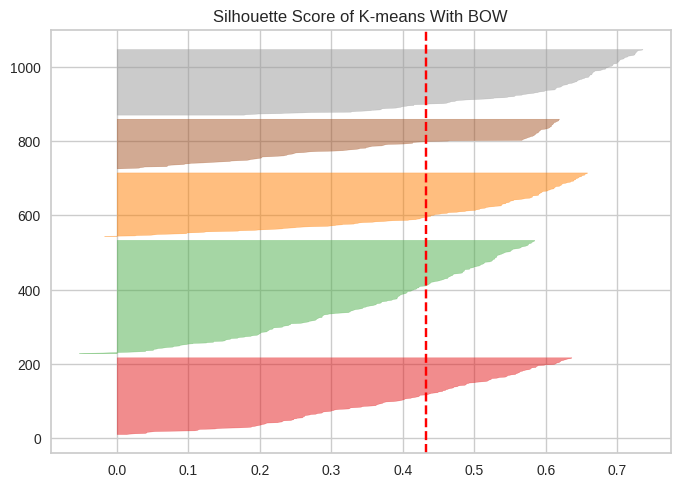

In [ ]:
KMeansSilhouetteVisualization(DataOfBOW, KMeansWithBOW,"BOW")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


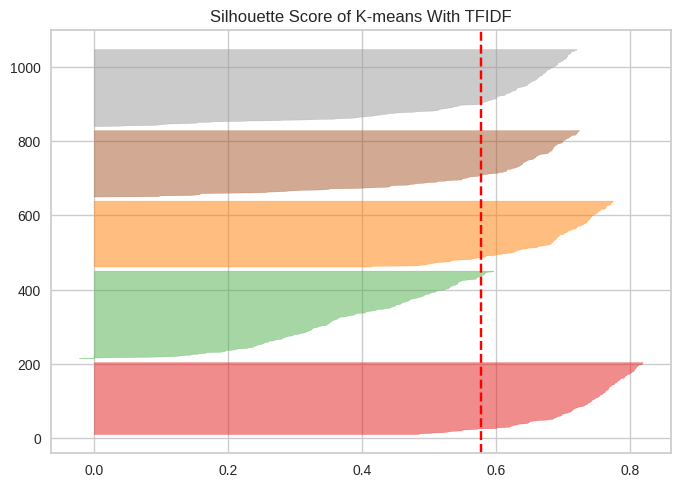

In [ ]:
KMeansSilhouetteVisualization(DataOfTFIDF, KMeansWithTFIDF, "TFIDF")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


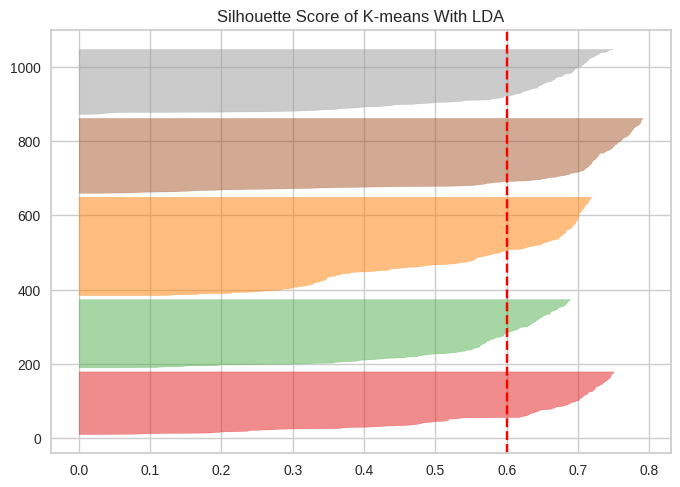

In [ ]:
KMeansSilhouetteVisualization(DataOfLDA, KMeansWithLDA,"LDA")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


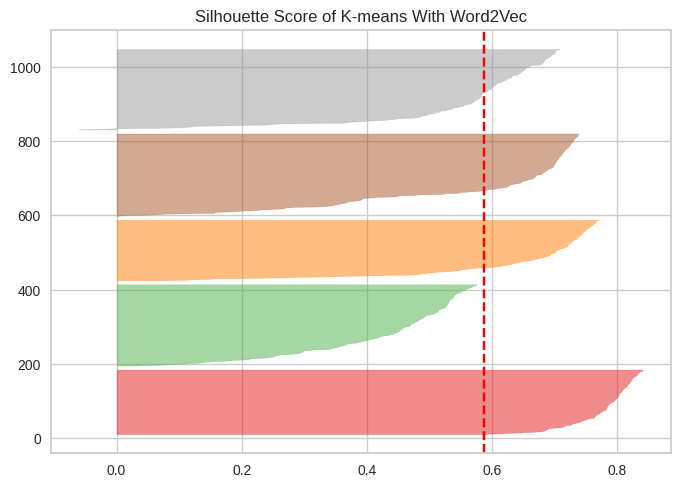

In [ ]:
KMeansSilhouetteVisualization(W2VData, W2VWithKMeans, "Word2Vec")

In [ ]:
def evaluate_Silhouette(data,pred, title=''):
    score = silhouette_score(data, pred)
    print(title,":",score)
    return score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Silhouette evaluation with K-means Algorithm

In [ ]:
Kmeans_Silhouette_score = []
Kmeans_Silhouette_score.append(evaluate_Silhouette(DataOfBOW,KMeansWithBOWPrediction,'Silhouette Score of K-means With BOW'))
Kmeans_Silhouette_score.append(evaluate_Silhouette(DataOfTFIDF,KMeansWithTFIDFPrediction,'Silhouette Score of K-means With TF-IDF'))
Kmeans_Silhouette_score.append(evaluate_Silhouette(DataOfLDA,KMeansWithLDAPrediction,'Silhouette Score of K-means With LDA'))
Kmeans_Silhouette_score.append(evaluate_Silhouette(W2VData,W2VWithKMeansPrediction,'Silhouette Score of K-means With Word2Vec'))
print("Kmeans Silhouette scores",Kmeans_Silhouette_score)

Silhouette Score of K-means With BOW : 0.43264297
Silhouette Score of K-means With TF-IDF : 0.57847035
Silhouette Score of K-means With LDA : 0.600884
Silhouette Score of K-means With Word2Vec : 0.58657855
Kmeans Silhouette scores [0.43264297, 0.57847035, 0.600884, 0.58657855]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Silhouette evaluation with Expectation Maximization (EM) Algorithm

In [ ]:
EM_Silhouette_score = []
EM_Silhouette_score.append(evaluate_Silhouette(DataOfBOW,EMWithBOWPrediction,'Silhouette Score of Expectation Maximization With BOW'))
EM_Silhouette_score.append(evaluate_Silhouette(DataOfTFIDF,EMWithTFIDFPrediction,'Silhouette Score of Expectation Maximization With TF-IDF'))
EM_Silhouette_score.append(evaluate_Silhouette(DataOfLDA,EMWithLDAPrediction,'Silhouette Score of Expectation Maximization With LDA'))
EM_Silhouette_score.append(evaluate_Silhouette(W2VData,W2VWithEMPrediction,'Silhouette Score of Expectation Maximization With Word2Vec'))
print("EM Silhouette scores",EM_Silhouette_score)

Silhouette Score of Expectation Maximization With BOW : 0.44599622
Silhouette Score of Expectation Maximization With TF-IDF : 0.5740476
Silhouette Score of Expectation Maximization With LDA : 0.57115
Silhouette Score of Expectation Maximization With Word2Vec : 0.61463964
EM Silhouette scores [0.44599622, 0.5740476, 0.57115, 0.61463964]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Silhouette with Hierarchical Algorithm

In [ ]:
Hierarchical_Silhouette_score =[]
Hierarchical_Silhouette_score.append(evaluate_Silhouette(DataOfBOW,AggClusteringWithBOWPrediction,'Silhouette Score of Hierarchical With BOW'))
Hierarchical_Silhouette_score.append(evaluate_Silhouette(DataOfTFIDF,HCWithTFIDFPrediction,'Silhouette Score of Hierarchical With TF-IDF'))
Hierarchical_Silhouette_score.append(evaluate_Silhouette(DataOfLDA,HCWithLDAPrediction,'Silhouette Score of Hierarchical With LDA'))
Hierarchical_Silhouette_score.append(evaluate_Silhouette(W2VData,W2VWithHCPrediction,'Silhouette Score of Hierarchical With Word2Vec'))
print("Hierarchical Silhouette scores",Hierarchical_Silhouette_score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Silhouette Score of Hierarchical With BOW : 0.41210836
Silhouette Score of Hierarchical With TF-IDF : 0.5730236
Silhouette Score of Hierarchical With LDA : 0.5929133
Silhouette Score of Hierarchical With Word2Vec : 0.57691103
Hierarchical Silhouette scores [0.41210836, 0.5730236, 0.5929133, 0.57691103]


In [ ]:
print(Kmeans_Kappa_score)
print(EM_Kappa_score)
print(Hierarchical_Kappa_score)
print(Kmeans_Silhouette_score)
print(EM_Silhouette_score)
print(Hierarchical_Silhouette_score)

[0.7362500000000001, 0.93625, 0.87, 0.84375]
[0.65875, 0.9275, 0.7262500000000001, 0.65875]
[0.8225, 0.9225, 0.89, 0.88375]
[0.43264297, 0.57847035, 0.600884, 0.58657855]
[0.44599622, 0.5740476, 0.57115, 0.61463964]
[0.41210836, 0.5730236, 0.5929133, 0.57691103]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Compare between scores to choose the champion model

In [ ]:
list_transformations=['BOW','TF-IDF','LDA','Word2Vec']
li=['Kmeans_Kappa_score',list_transformations[Kmeans_Kappa_score.index(max(Kmeans_Kappa_score))],max(Kmeans_Kappa_score)]
li

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Kmeans_Kappa_score', 'TF-IDF', 0.93625]

In [ ]:
# Define the lists of scores
list_transformations=['BOW','TF-IDF','LDA','Word2Vec']
lists = [
   ['Kmeans_Kappa_score',list_transformations[Kmeans_Kappa_score.index(max(Kmeans_Kappa_score))],max(Kmeans_Kappa_score)],
   ['EM_Kappa_score',list_transformations[EM_Kappa_score.index(max(EM_Kappa_score))],max(EM_Kappa_score)],
   ['Hierarchical_Kappa_score',list_transformations[Hierarchical_Kappa_score.index(max(Hierarchical_Kappa_score))],max(Hierarchical_Kappa_score)],
   ['Kmeans_Silhouette_score',list_transformations[Kmeans_Silhouette_score.index(max(Kmeans_Silhouette_score))],max(Kmeans_Silhouette_score)],
   ['EM_Silhouette_score',list_transformations[EM_Silhouette_score.index(max(EM_Silhouette_score))],max(EM_Silhouette_score)],
   ['Hierarchical_Silhouette_score',list_transformations[Hierarchical_Silhouette_score.index(max(Hierarchical_Silhouette_score))],max(Hierarchical_Silhouette_score)]
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Kmeans_Kappa_TSNE=['Kmeans_Kappa_score',list_transformations[Kmeans_Kappa_score.index(max(Kmeans_Kappa_score))],max(Kmeans_Kappa_score)]
Kmeans_Silhouette_TSNE=['Kmeans_Silhouette_score',list_transformations[Kmeans_Silhouette_score.index(max(Kmeans_Silhouette_score))],max(Kmeans_Silhouette_score)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create empty lists to store the values and titles
values = []
titles = []

# Extract the values and titles from the filtered list
for item in lists:
    titles.append(item[0] + ' (' + item[1] + ')')
    values.append(item[2])
print(values)
print(titles)

[0.93625, 0.9275, 0.9225, 0.600884, 0.61463964, 0.5929133]
['Kmeans_Kappa_score (TF-IDF)', 'EM_Kappa_score (TF-IDF)', 'Hierarchical_Kappa_score (TF-IDF)', 'Kmeans_Silhouette_score (LDA)', 'EM_Silhouette_score (Word2Vec)', 'Hierarchical_Silhouette_score (LDA)']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Champion Model
Based on comparsion between score of each model with every text transformation technique, we choose K-Means algorithm with TF-IDF Technique that has the highest score in Kappa evaluation with 0.938

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


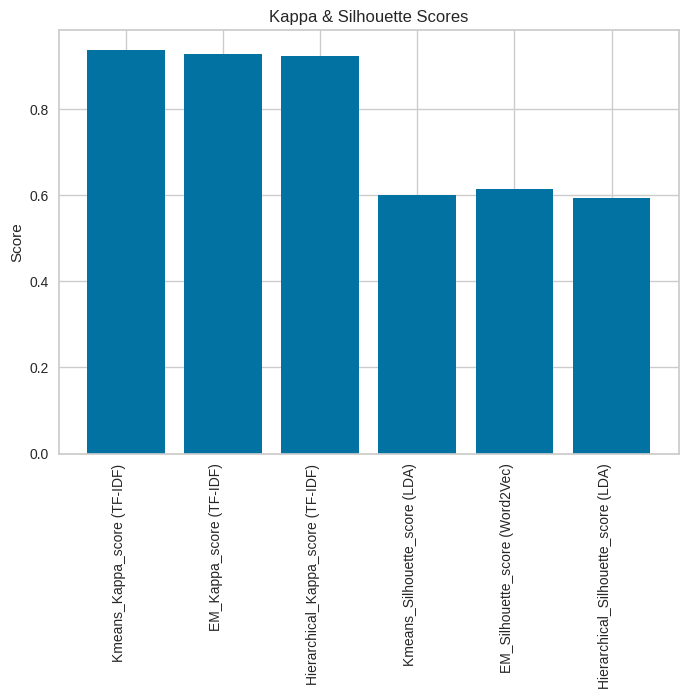

In [ ]:
# Plot the values with titles
plt.bar(titles, values)
plt.title('Kappa & Silhouette Scores')
plt.ylabel('Score')
plt.xticks(rotation=90, ha='right')
plt.show()

### (7) Error Analysis  

#### Data without any Feature Reductions

In [ ]:
DataOfBOW= df_books_BOW
DataOfTFIDF = df_books_tf_idf
DataOfLDA = PredictedWords[0]
W2VData=document_embeddings


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# function to apply kmeans algorithm
def KMeansAlgorithm(clusters, X_data):
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    Y_Prediction = kmeans.fit_predict(X_data)
    return kmeans, Y_Prediction







/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


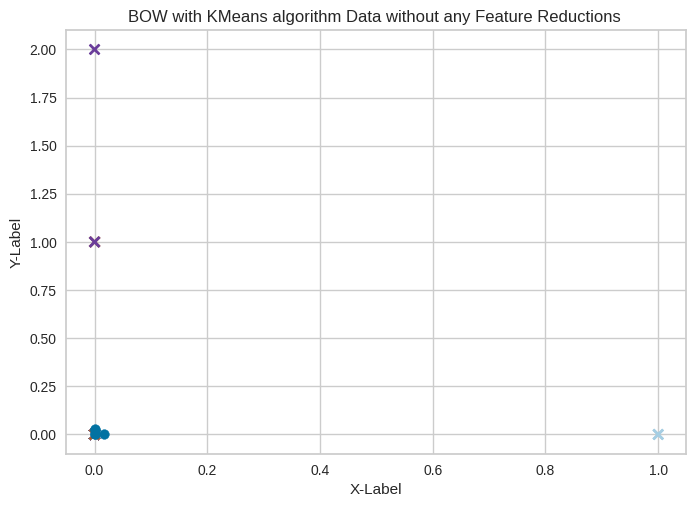

In [ ]:
# Bow with KMeans algorithm
KMeansWithBOW, KMeansWithBOWPrediction = KMeansAlgorithm(5,DataOfBOW)
# visualize clusters
Visualize_Clusters(KMeansWithBOW, DataOfBOW, KMeansWithBOWPrediction,False,title='BOW with KMeans algorithm Data without any Feature Reductions ')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


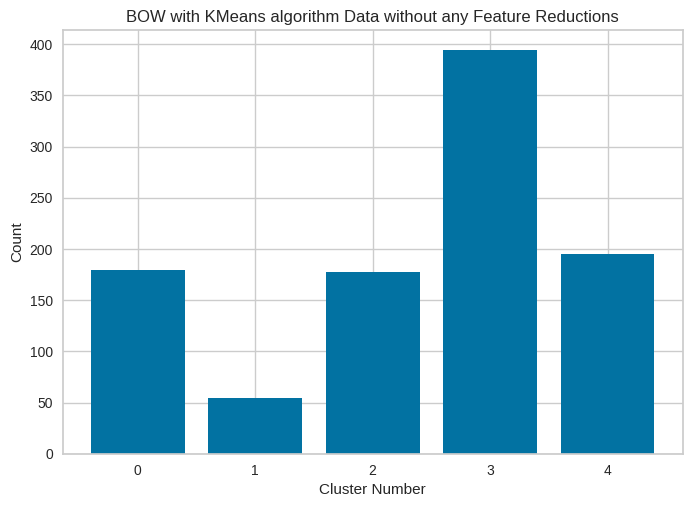

In [ ]:
Clusters_Count(KMeansWithBOWPrediction,title='BOW with KMeans algorithm Data without any Feature Reductions')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


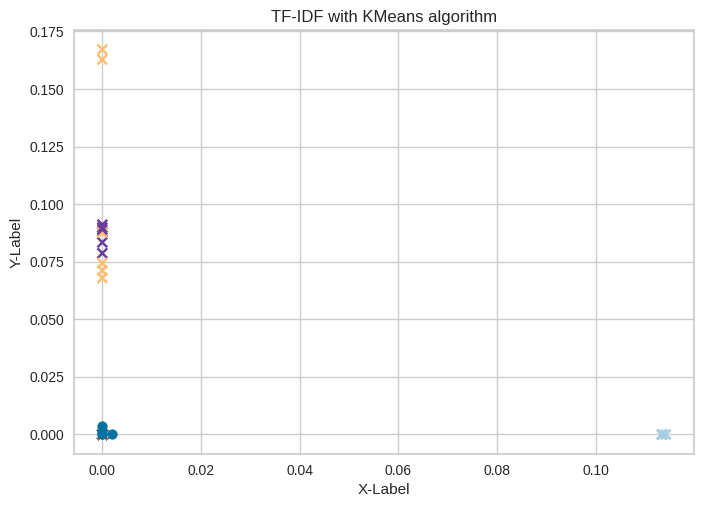

In [ ]:
# tf-idf with KMeans algorithm
KMeansWithTFIDF, KMeansWithTFIDFPrediction = KMeansAlgorithm(5,DataOfTFIDF)
# visualize clusters
Visualize_Clusters(KMeansWithTFIDF, DataOfTFIDF, KMeansWithTFIDFPrediction,False,title='TF-IDF with KMeans algorithm')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


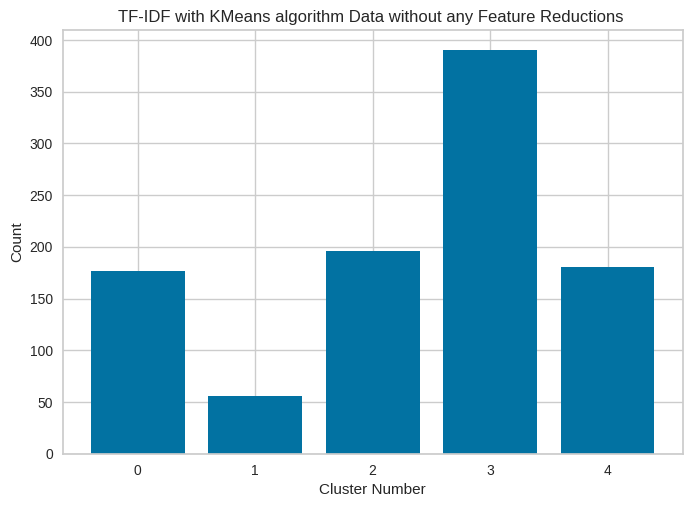

In [ ]:
# visualize cluster number
Clusters_Count(KMeansWithTFIDFPrediction,title='TF-IDF with KMeans algorithm Data without any Feature Reductions ')

In [ ]:
# LDA with KMeans algorithm
KMeansWithLDA, KMeansWithLDAPrediction = KMeansAlgorithm(5,DataOfLDA)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


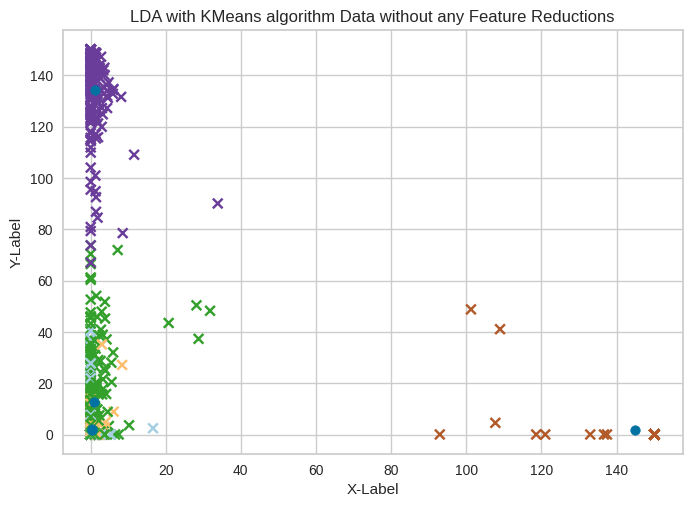

In [ ]:
# visualize clusters
Visualize_Clusters(KMeansWithLDA, DataOfLDA, KMeansWithLDAPrediction,False,title='LDA with KMeans algorithm Data without any Feature Reductions')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


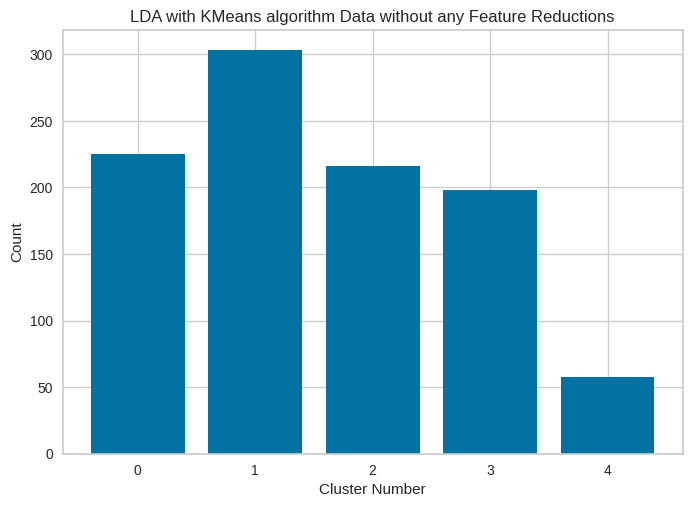

In [ ]:
# visualize cluster number
Clusters_Count(KMeansWithLDAPrediction,title='LDA with KMeans algorithm Data without any Feature Reductions')

In [ ]:
# word2vec with Kmeans
W2VWithKMeans, W2VWithKMeansPrediction = KMeansAlgorithm(5,W2VData)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


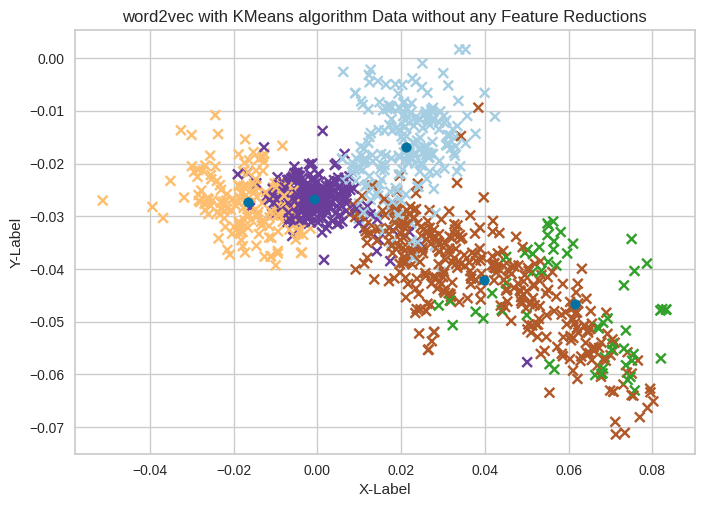

In [ ]:
Visualize_Clusters(W2VWithKMeans, W2VData, W2VWithKMeansPrediction,False,title='word2vec with KMeans algorithm Data without any Feature Reductions')###################

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


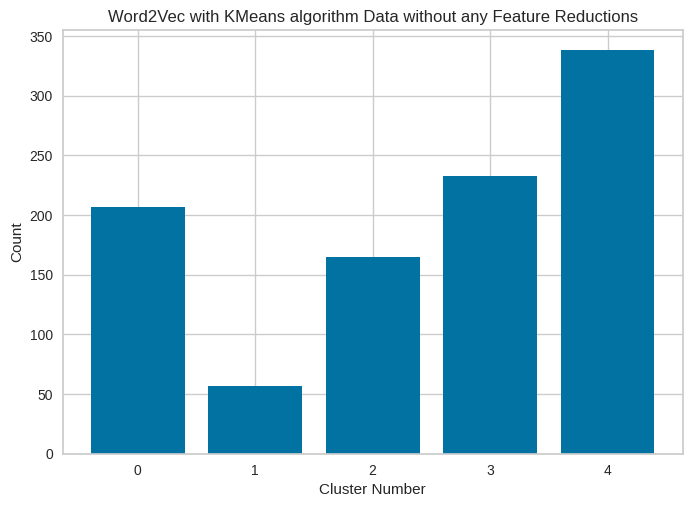

In [ ]:
Clusters_Count(W2VWithKMeansPrediction,title='Word2Vec with KMeans algorithm Data without any Feature Reductions')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
x=kappa_implement(KMeansWithBOWPrediction,'Kappa with K-means for BOW')
print(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Kappa with K-means for BOW
Label counts for cluster 0: [177, 0, 0, 0, 2]
Label counts for cluster 1: [22, 18, 10, 2, 2]
Label counts for cluster 2: [0, 0, 0, 0, 178]
Label counts for cluster 3: [1, 1, 190, 197, 5]
Label counts for cluster 4: [0, 181, 0, 1, 13]
Kappa Score:  0.69375
0.69375


In [ ]:
Kmeans_Kappa_score =[]
Kmeans_Kappa_score.append(kappa_implement(KMeansWithBOWPrediction,'Kappa with K-means for BOW'))
Kmeans_Kappa_score.append(kappa_implement(KMeansWithTFIDFPrediction,'Kappa with K-means for TF-IDF'))
Kmeans_Kappa_score.append(kappa_implement(KMeansWithLDAPrediction,'Kappa with K-means for LDA'))
Kmeans_Kappa_score.append(kappa_implement(W2VWithKMeansPrediction,'Kappa with K-means for Word2Vec'))
print("Kappa Scores with Kmeans",Kmeans_Kappa_score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Kappa with K-means for BOW
Label counts for cluster 0: [177, 0, 0, 0, 2]
Label counts for cluster 1: [22, 18, 10, 2, 2]
Label counts for cluster 2: [0, 0, 0, 0, 178]
Label counts for cluster 3: [1, 1, 190, 197, 5]
Label counts for cluster 4: [0, 181, 0, 1, 13]
Kappa Score:  0.69375
Kappa with K-means for TF-IDF
Label counts for cluster 0: [177, 0, 0, 0, 0]
Label counts for cluster 1: [22, 19, 11, 2, 2]
Label counts for cluster 2: [0, 0, 0, 0, 196]
Label counts for cluster 3: [1, 1, 189, 198, 1]
Label counts for cluster 4: [0, 180, 0, 0, 1]
Kappa Score:  0.71625
Kappa with K-means for LDA
Label counts for cluster 0: [177, 48, 0, 0, 0]
Label counts for cluster 1: [0, 114, 0, 189, 0]
Label counts for cluster 2: [0, 18, 0, 0, 198]
Label counts for cluster 3: [0, 0, 189, 9, 0]
Label counts for cluster 4: [23, 20, 11, 2, 2]
Kappa Score:  0.72000
Kappa with K-means for Word2Vec
Label counts for cluster 0: [177, 30, 0, 0, 0]
Label counts for cluster 1: [23, 19, 11, 2, 2]
Label counts for clust

In [ ]:
def KMeansSilhouetteVisualization(data, model, title):
    visualizerOfSilhouette = SilhouetteVisualizer(model)
    visualizerOfSilhouette.fit(data)
    plt.title("Silhouette Score of K-means With " + title)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. 

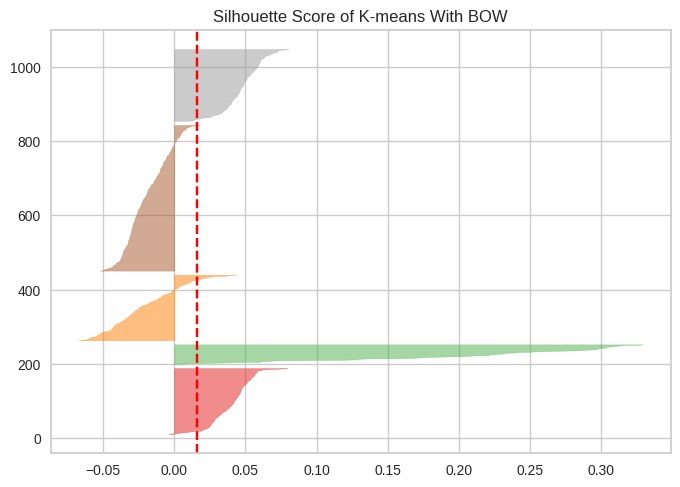

In [ ]:
KMeansSilhouetteVisualization(DataOfBOW, KMeansWithBOW,"BOW")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. 

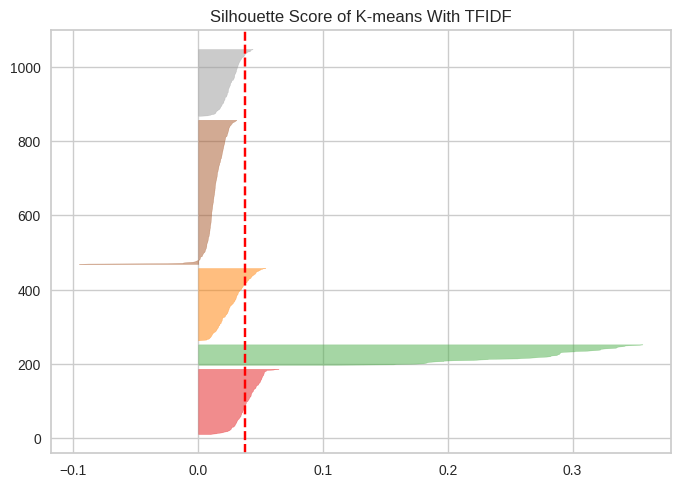

In [ ]:
KMeansSilhouetteVisualization(DataOfTFIDF, KMeansWithTFIDF, "TFIDF")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


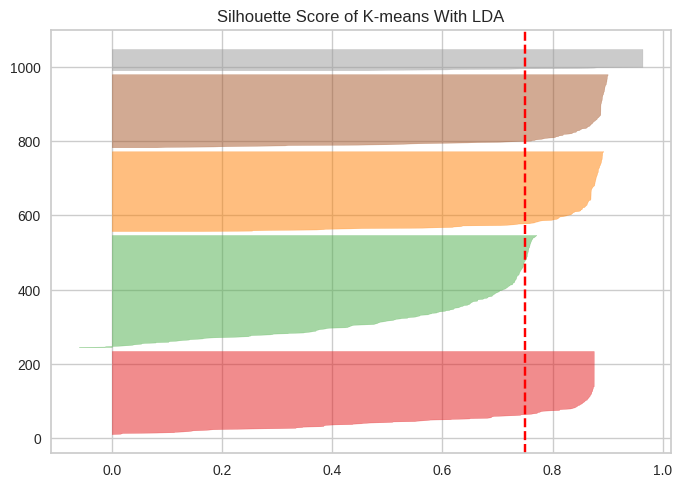

In [ ]:
KMeansSilhouetteVisualization(DataOfLDA, KMeansWithLDA,"LDA")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


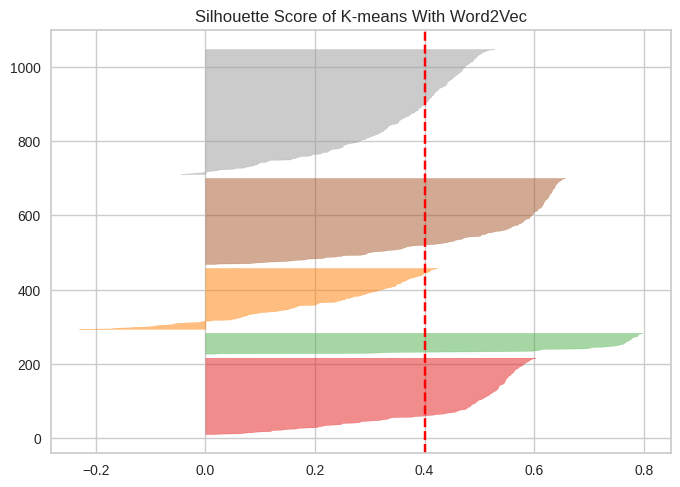

In [ ]:
KMeansSilhouetteVisualization(W2VData, W2VWithKMeans, "Word2Vec")

In [ ]:
def evaluate_Silhouette(data,pred, title=''):
    score = silhouette_score(data, pred)
    print(title,":",score)
    return score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Kmeans_Silhouette_score = []
Kmeans_Silhouette_score.append(evaluate_Silhouette(DataOfBOW,KMeansWithBOWPrediction,'Silhouette Score of K-means With BOW'))
Kmeans_Silhouette_score.append(evaluate_Silhouette(DataOfTFIDF,KMeansWithTFIDFPrediction,'Silhouette Score of K-means With TF-IDF'))
Kmeans_Silhouette_score.append(evaluate_Silhouette(DataOfLDA,KMeansWithLDAPrediction,'Silhouette Score of K-means With LDA'))
Kmeans_Silhouette_score.append(evaluate_Silhouette(W2VData,W2VWithKMeansPrediction,'Silhouette Score of K-means With Word2Vec'))
print("Kmeans Silhouette scores",Kmeans_Silhouette_score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Silhouette Score of K-means With BOW : 0.01606357002655911
Silhouette Score of K-means With TF-IDF : 0.03713642495891699
Silhouette Score of K-means With LDA : 0.7493197
Silhouette Score of K-means With Word2Vec : 0.4011288
Kmeans Silhouette scores [0.01606357002655911, 0.03713642495891699, 0.7493197, 0.4011288]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define the lists of scores
list_transformations=['BOW','TF-IDF','LDA','Word2Vec']
lists = [
   ['Kmeans_Kappa_score',list_transformations[Kmeans_Kappa_score.index(max(Kmeans_Kappa_score))],max(Kmeans_Kappa_score)],

   ['Kmeans_Silhouette_score',list_transformations[Kmeans_Silhouette_score.index(max(Kmeans_Silhouette_score))],max(Kmeans_Silhouette_score)]
     ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Kmeans_Kappa_DWFR=['Kmeans_Kappa_score',list_transformations[Kmeans_Kappa_score.index(max(Kmeans_Kappa_score))],max(Kmeans_Kappa_score)],

Kmeans_Silhouette_DWFR= ['Kmeans_Silhouette_score',list_transformations[Kmeans_Silhouette_score.index(max(Kmeans_Silhouette_score))],max(Kmeans_Silhouette_score)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create empty lists to store the values and titles
values = []
titles = []

# Extract the values and titles from the filtered list
for item in lists:
    titles.append(item[0] + ' (' + item[1] + ')')
    values.append(item[2])
print(values)
print(titles)

[0.72, 0.7493197]
['Kmeans_Kappa_score (LDA)', 'Kmeans_Silhouette_score (LDA)']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


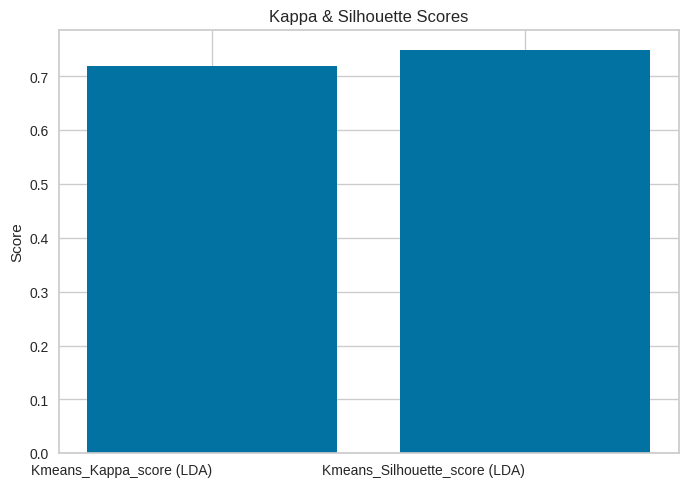

In [ ]:
# Plot the values with titles
plt.bar(titles, values)
plt.title('Kappa & Silhouette Scores')
plt.ylabel('Score')
plt.xticks(rotation=0, ha='right')
plt.show()

#### With PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def  pcadata(data):
    x = StandardScaler().fit_transform(data)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data)
    return principalComponents


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
DataOfBOW=pcadata(df_books_BOW)
DataOfTFIDF=pcadata(df_books_tf_idf)
DataOfLDA=pcadata(PredictedWords[0])
W2VData=pcadata(document_embeddings)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# function to apply kmeans algorithm
def KMeansAlgorithm(clusters, X_data):
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    Y_Prediction = kmeans.fit_predict(X_data)
    return kmeans, Y_Prediction







/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


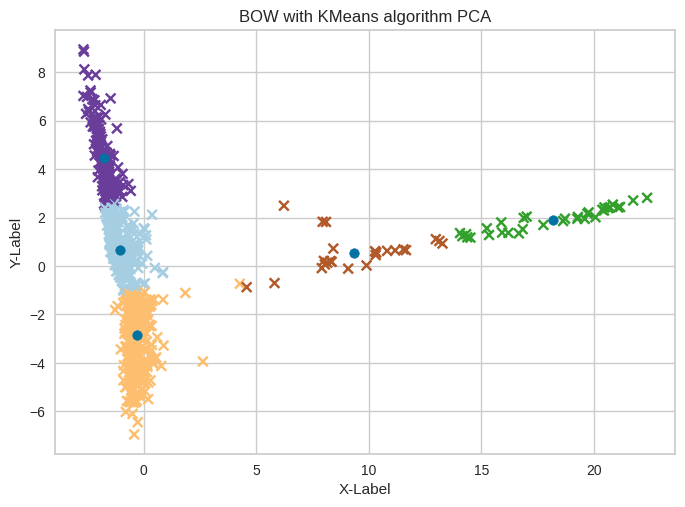

In [ ]:
# Bow with KMeans algorithm
KMeansWithBOW, KMeansWithBOWPrediction = KMeansAlgorithm(5,DataOfBOW)
# visualize clusters
Visualize_Clusters(KMeansWithBOW, DataOfBOW, KMeansWithBOWPrediction,False,title='BOW with KMeans algorithm PCA')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


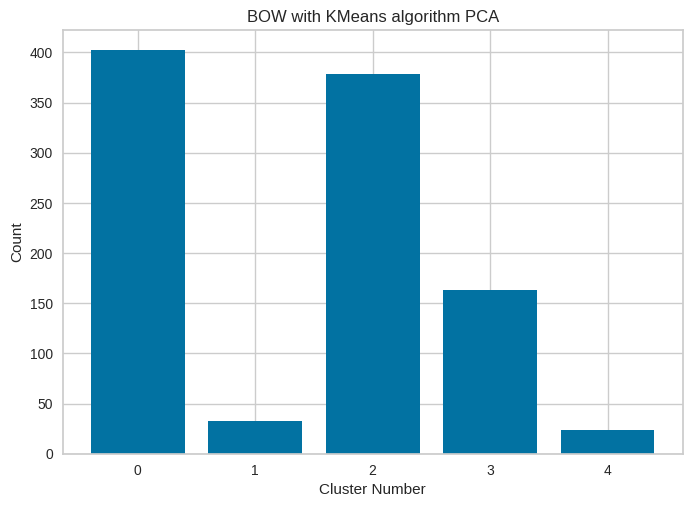

In [ ]:
Clusters_Count(KMeansWithBOWPrediction,title='BOW with KMeans algorithm PCA')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


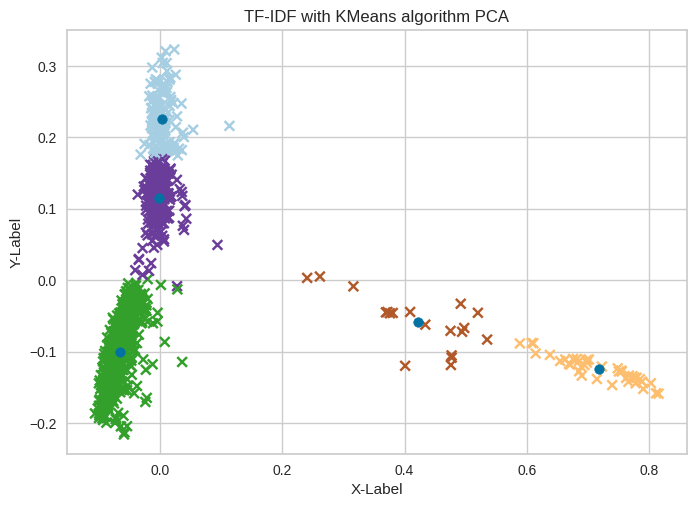

In [ ]:
# tf-idf with KMeans algorithm
KMeansWithTFIDF, KMeansWithTFIDFPrediction = KMeansAlgorithm(5,DataOfTFIDF)
# visualize clusters
Visualize_Clusters(KMeansWithTFIDF, DataOfTFIDF, KMeansWithTFIDFPrediction,False,title='TF-IDF with KMeans algorithm PCA')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


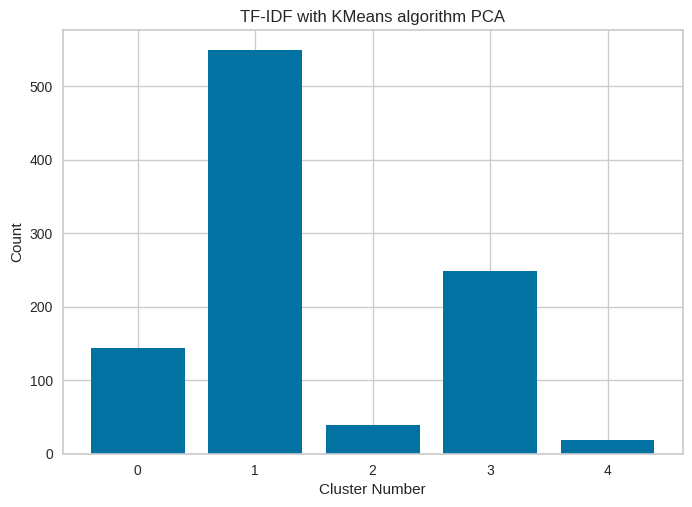

In [ ]:
# visualize cluster number
Clusters_Count(KMeansWithTFIDFPrediction,title='TF-IDF with KMeans algorithm PCA')

In [ ]:
# LDA with KMeans algorithm
KMeansWithLDA, KMeansWithLDAPrediction = KMeansAlgorithm(5,DataOfLDA)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


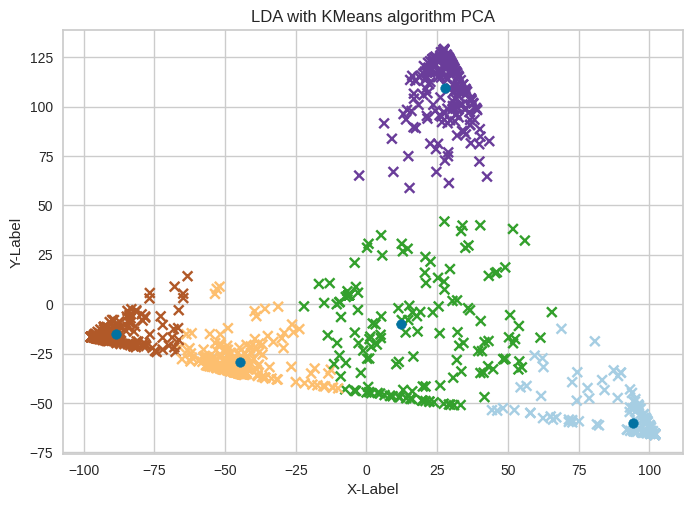

In [ ]:
# visualize clusters
Visualize_Clusters(KMeansWithLDA, DataOfLDA, KMeansWithLDAPrediction,False,title='LDA with KMeans algorithm PCA')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


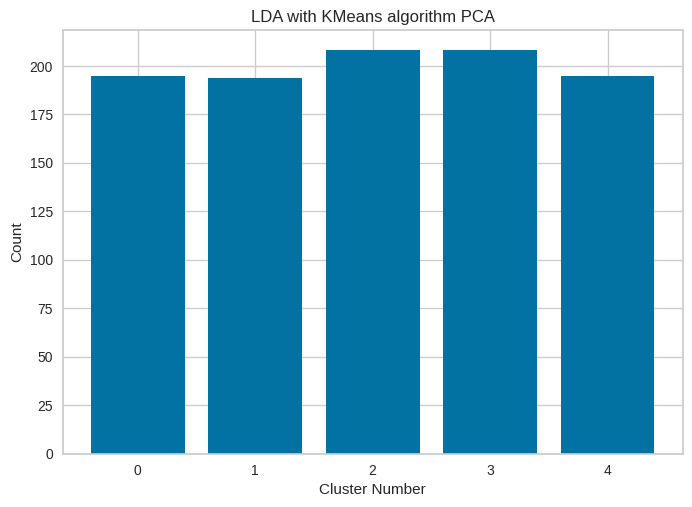

In [ ]:
# visualize cluster number
Clusters_Count(KMeansWithLDAPrediction,title='LDA with KMeans algorithm PCA')

In [ ]:
# word2vec with Kmeans
W2VWithKMeans, W2VWithKMeansPrediction = KMeansAlgorithm(5,W2VData)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


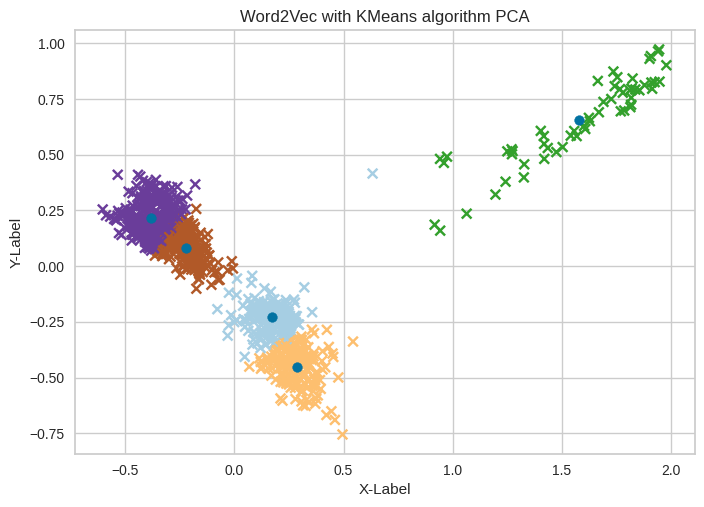

In [ ]:
Visualize_Clusters(W2VWithKMeans, W2VData, W2VWithKMeansPrediction,False,title='Word2Vec with KMeans algorithm PCA') ##############################

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


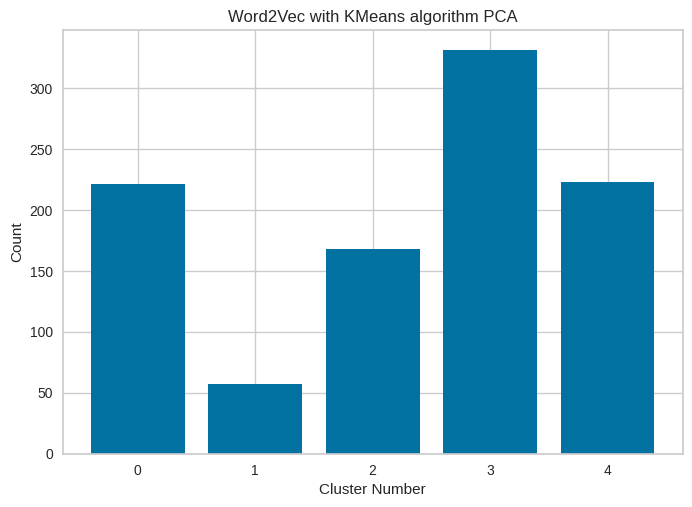

In [ ]:
Clusters_Count(W2VWithKMeansPrediction,title='Word2Vec with KMeans algorithm PCA')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
x=kappa_implement(KMeansWithBOWPrediction,'Kappa with K-means for BOW')
print(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Kappa with K-means for BOW
Label counts for cluster 0: [177, 167, 7, 4, 47]
Label counts for cluster 1: [13, 12, 5, 1, 2]
Label counts for cluster 2: [0, 2, 182, 194, 0]
Label counts for cluster 3: [0, 12, 0, 0, 151]
Label counts for cluster 4: [10, 7, 6, 1, 0]
Kappa Score:  0.43125
0.4312499999999999


In [ ]:
Kmeans_Kappa_score =[]
Kmeans_Kappa_score.append(kappa_implement(KMeansWithBOWPrediction,'Kappa with K-means for BOW'))
Kmeans_Kappa_score.append(kappa_implement(KMeansWithTFIDFPrediction,'Kappa with K-means for TF-IDF'))
Kmeans_Kappa_score.append(kappa_implement(KMeansWithLDAPrediction,'Kappa with K-means for LDA'))
Kmeans_Kappa_score.append(kappa_implement(W2VWithKMeansPrediction,'Kappa with K-means for Word2Vec'))
print("Kappa Scores with Kmeans",Kmeans_Kappa_score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Kappa with K-means for BOW
Label counts for cluster 0: [177, 167, 7, 4, 47]
Label counts for cluster 1: [13, 12, 5, 1, 2]
Label counts for cluster 2: [0, 2, 182, 194, 0]
Label counts for cluster 3: [0, 12, 0, 0, 151]
Label counts for cluster 4: [10, 7, 6, 1, 0]
Kappa Score:  0.43125
Kappa with K-means for TF-IDF
Label counts for cluster 0: [0, 0, 17, 127, 0]
Label counts for cluster 1: [177, 175, 0, 0, 197]
Label counts for cluster 2: [17, 12, 6, 2, 2]
Label counts for cluster 3: [0, 5, 172, 71, 1]
Label counts for cluster 4: [6, 8, 5, 0, 0]
Kappa Score:  0.40125
Kappa with K-means for LDA
Label counts for cluster 0: [177, 18, 0, 0, 0]
Label counts for cluster 1: [23, 151, 9, 7, 4]
Label counts for cluster 2: [0, 19, 3, 186, 0]
Label counts for cluster 3: [0, 12, 0, 0, 196]
Label counts for cluster 4: [0, 0, 188, 7, 0]
Kappa Score:  0.87250
Kappa with K-means for Word2Vec
Label counts for cluster 0: [0, 3, 171, 46, 1]
Label counts for cluster 1: [23, 19, 11, 2, 2]
Label counts for clus

In [ ]:
def KMeansSilhouetteVisualization(data, model, title):
    visualizerOfSilhouette = SilhouetteVisualizer(model)
    visualizerOfSilhouette.fit(data)
    plt.title("Silhouette Score of K-means With " + title)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


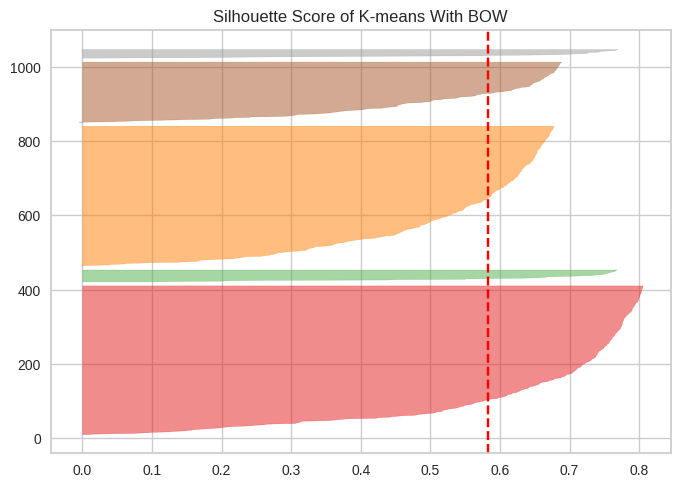

In [ ]:
KMeansSilhouetteVisualization(DataOfBOW, KMeansWithBOW,"BOW")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


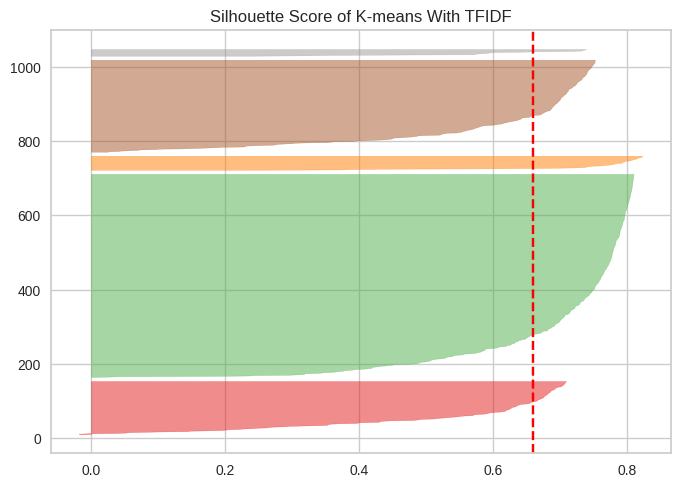

In [ ]:
KMeansSilhouetteVisualization(DataOfTFIDF, KMeansWithTFIDF, "TFIDF")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


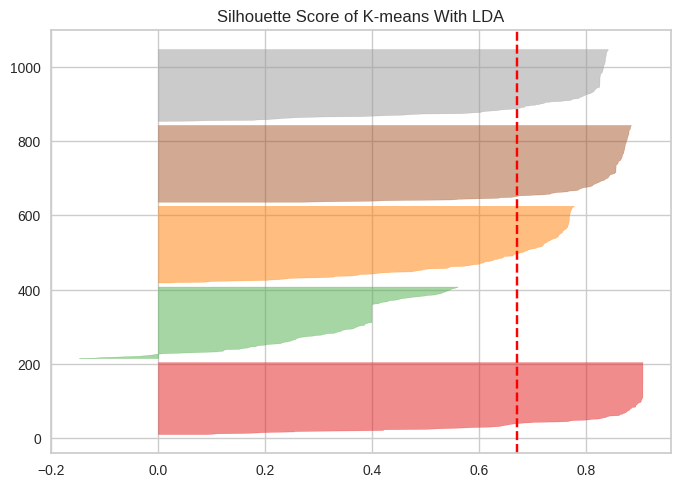

In [ ]:
KMeansSilhouetteVisualization(DataOfLDA, KMeansWithLDA,"LDA")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/yellowbrick/style/colors.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(colormap)


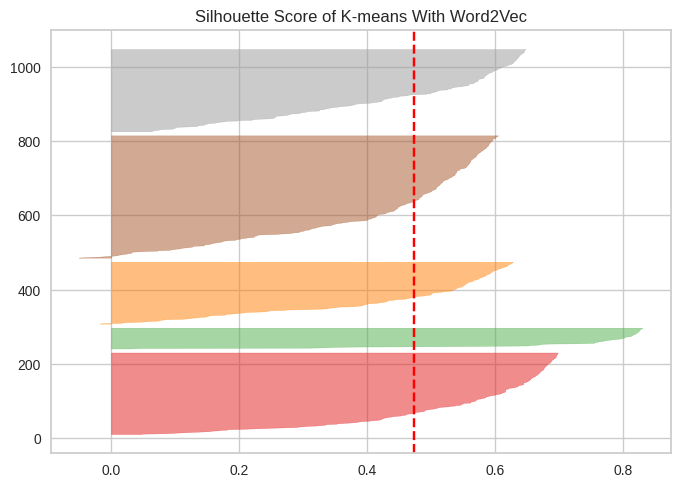

In [ ]:
KMeansSilhouetteVisualization(W2VData, W2VWithKMeans, "Word2Vec")

In [ ]:
def evaluate_Silhouette(data,pred, title=''):
    score = silhouette_score(data, pred)
    print(title,":",score)
    return score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Kmeans_Silhouette_score = []
Kmeans_Silhouette_score.append(evaluate_Silhouette(DataOfBOW,KMeansWithBOWPrediction,'Silhouette Score of K-means With BOW'))
Kmeans_Silhouette_score.append(evaluate_Silhouette(DataOfTFIDF,KMeansWithTFIDFPrediction,'Silhouette Score of K-means With TF-IDF'))
Kmeans_Silhouette_score.append(evaluate_Silhouette(DataOfLDA,KMeansWithLDAPrediction,'Silhouette Score of K-means With LDA'))
Kmeans_Silhouette_score.append(evaluate_Silhouette(W2VData,W2VWithKMeansPrediction,'Silhouette Score of K-means With Word2Vec'))
print("Kmeans Silhouette scores",Kmeans_Silhouette_score)

Silhouette Score of K-means With BOW : 0.5826974180374797
Silhouette Score of K-means With TF-IDF : 0.6605767367924366
Silhouette Score of K-means With LDA : 0.6709777
Silhouette Score of K-means With Word2Vec : 0.47352907
Kmeans Silhouette scores [0.5826974180374797, 0.6605767367924366, 0.6709777, 0.47352907]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define the lists of scores
list_transformations=['BOW','TF-IDF','LDA','Word2Vec']
lists = [
   ['Kmeans_Kappa_score',list_transformations[Kmeans_Kappa_score.index(max(Kmeans_Kappa_score))],max(Kmeans_Kappa_score)],

   ['Kmeans_Silhouette_score',list_transformations[Kmeans_Silhouette_score.index(max(Kmeans_Silhouette_score))],max(Kmeans_Silhouette_score)]
     ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
 Kmeans_Kappa_PCA=['Kmeans_Kappa_score',list_transformations[Kmeans_Kappa_score.index(max(Kmeans_Kappa_score))],max(Kmeans_Kappa_score)],

 Kmeans_Silhouette_PCA=['Kmeans_Silhouette_score',list_transformations[Kmeans_Silhouette_score.index(max(Kmeans_Silhouette_score))],max(Kmeans_Silhouette_score)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create empty lists to store the values and titles
values = []
titles = []

# Extract the values and titles from the filtered list
for item in lists:
    titles.append(item[0] + ' (' + item[1] + ')')
    values.append(item[2])
print(values)
print(titles)

[0.8725, 0.6709777]
['Kmeans_Kappa_score (LDA)', 'Kmeans_Silhouette_score (LDA)']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


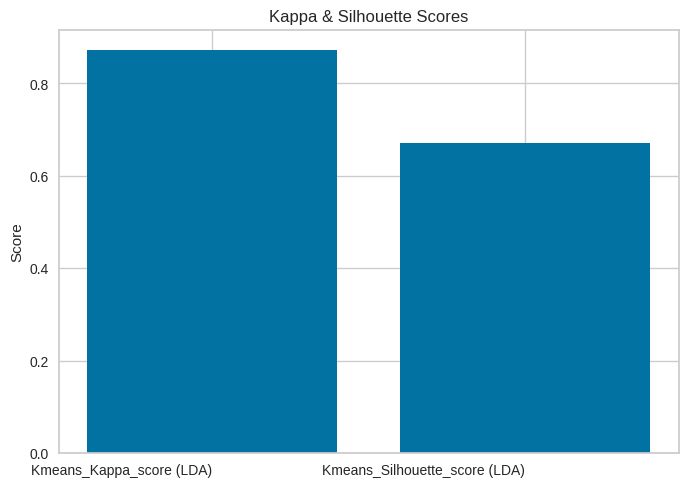

In [ ]:
# Plot the values with titles
plt.bar(titles, values)
plt.title('Kappa & Silhouette Scores')
plt.ylabel('Score')
plt.xticks(rotation=00, ha='right')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Kmeans_Silhouette_TSNE
Kmeans_Silhouette_DWFR
Kmeans_Silhouette_PCA

Kmeans_Kappa_TSNE
Kmeans_Kappa_DWFR
Kmeans_Kappa_PCA



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(['Kmeans_Kappa_score', 'LDA', 0.8725],)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


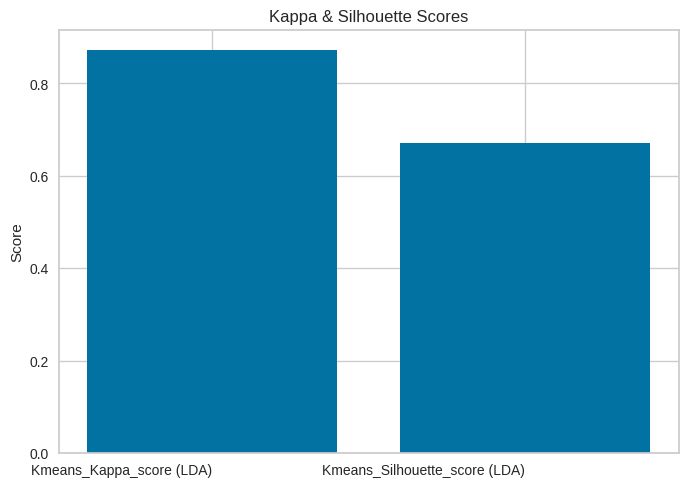

In [ ]:
# Plot the values with titles
plt.bar(titles, values)
plt.title('Kappa & Silhouette Scores')
plt.ylabel('Score')
plt.xticks(rotation=00, ha='right')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lists=[Kmeans_Silhouette_TSNE,
Kmeans_Silhouette_DWFR,
Kmeans_Silhouette_PCA,
]
ls=['TSNE','DWFR','PCA']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lists

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['Kmeans_Silhouette_score', 'LDA', 0.600884],
 ['Kmeans_Silhouette_score', 'LDA', 0.7493197],
 ['Kmeans_Silhouette_score', 'LDA', 0.6709777]]

In [ ]:
# Create empty lists to store the values and titles
values = []
titles = []

# Extract the values and titles from the filtered list
for i,item in enumerate(lists):
    titles.append(item[0] + ' (' + ls[i]+')')
    values.append(item[2])
print(values)
print(titles)

[0.600884, 0.7493197, 0.6709777]
['Kmeans_Silhouette_score (TSNE)', 'Kmeans_Silhouette_score (DWFR)', 'Kmeans_Silhouette_score (PCA)']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


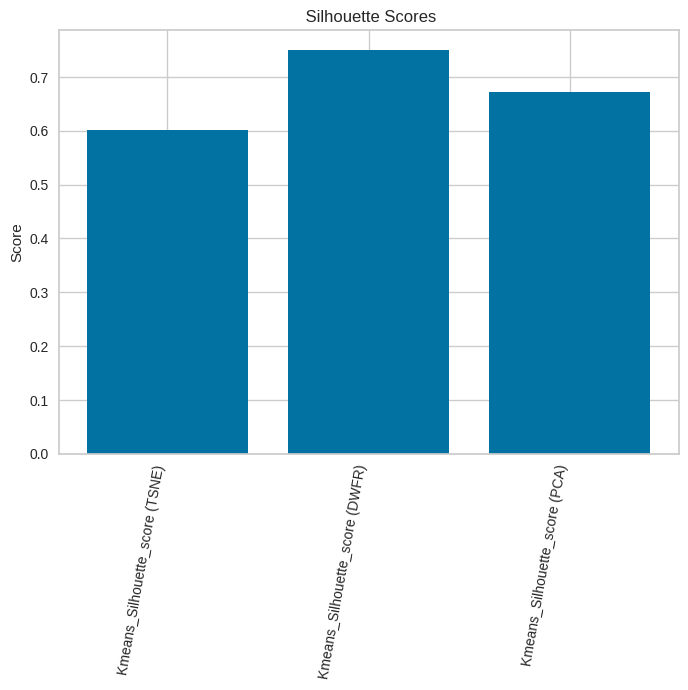

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# x and y are lists
plt.bar(titles, values)
plt.title(' Silhouette Scores')
plt.ylabel('Score')
plt.xticks(rotation=80, ha='right')
plt.show()
plt.show()

In [ ]:
lists=[ Kmeans_Kappa_TSNE,
list(Kmeans_Kappa_DWFR)[0],
list(Kmeans_Kappa_PCA)[0] ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create empty lists to store the values and titles
values = []
titles = []

# Extract the values and titles from the filtered list
for i,item in enumerate(lists):
    titles.append(item[0] + ' (' + ls[i]+')')
    values.append(item[2])
print(values)
print(titles)

[0.93625, 0.72, 0.8725]
['Kmeans_Kappa_score (TSNE)', 'Kmeans_Kappa_score (DWFR)', 'Kmeans_Kappa_score (PCA)']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


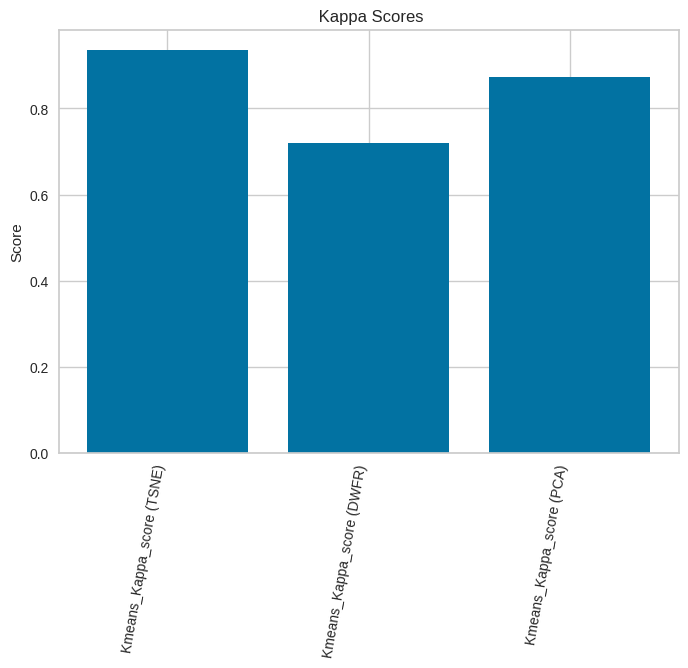

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# x and y are lists
plt.bar(titles, values)
plt.title(' Kappa Scores')
plt.ylabel('Score')
plt.xticks(rotation=80, ha='right')
plt.show()
plt.show()

#### Identity what were the characteristics of the instance records that threw the machine off, using the top 10 frequent words and/or top collocations.

#### as we notice in LDA Visualization, there are common words in both of them  For topic 1 & 4

In [ ]:
# function to plot top 10 words for desired topic
def top_10_words(i,title=''):
  common_words = get_top_n_words(df_books[df_books['label']==i]['sentence'], 10)
  #for word, freq in common_words:
      #print(word, freq)
  print(title)
  df1 = pd.DataFrame(common_words, columns = ['word' , 'count'])
  #df1.groupby('word').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 10 words')
  #print(Author_dic.get(i))
  fig, ax = plt.subplots()
  ax.barh(df1['word'], df1['count'])
  ax.legend(df_books[df_books['label']==i]['author'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 10 words in topic 1


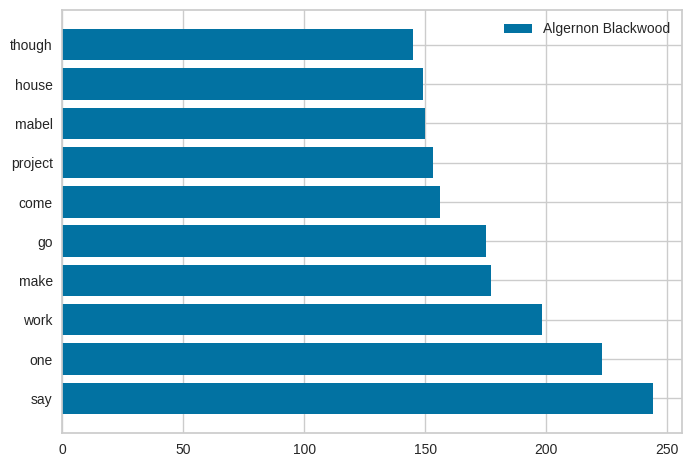

In [ ]:
# for topic 1
top_10_words(1,'Top 10 words in topic 1')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 10 words in topic 4


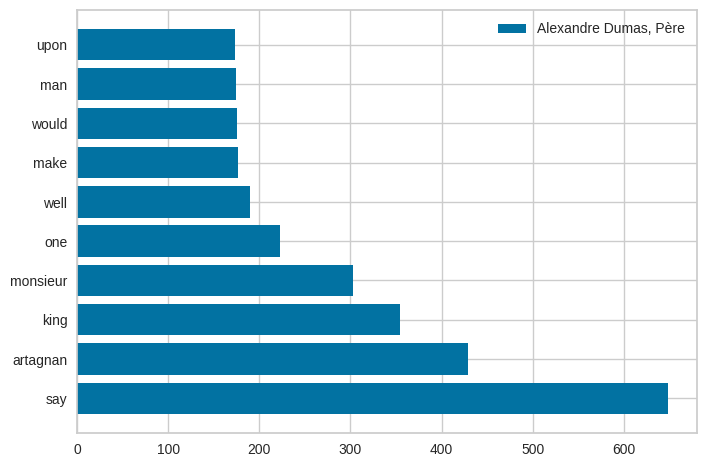

In [ ]:
# for topic 4
top_10_words(4,'Top 10 words in topic 4')

#### as we notice in LDA Visualization, there are common words in both of them For topic 2 & 3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 10 words in topic 2


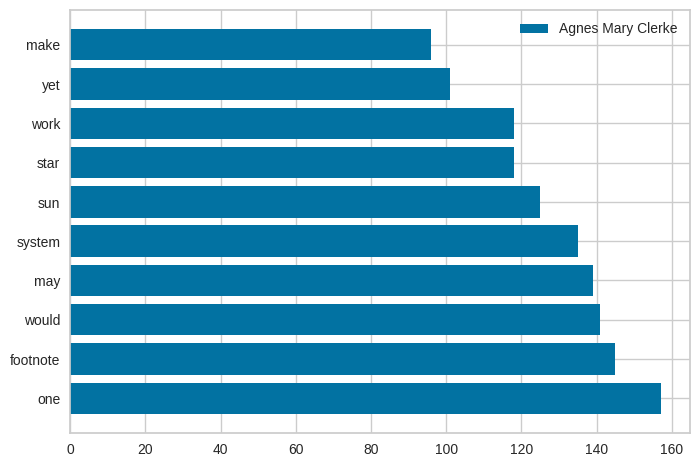

In [ ]:
# for topic 2
top_10_words(2,'Top 10 words in topic 2')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 10 words in topic 3


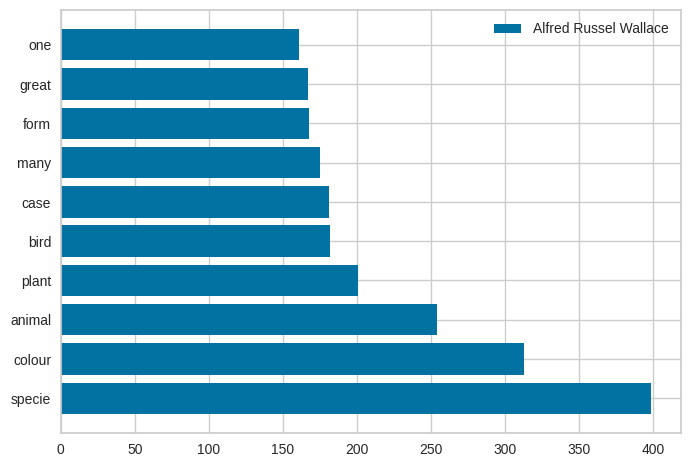

In [ ]:
# for topic 3
top_10_words(3,'Top 10 words in topic 3')